# 09.08(토)~ 해야할 것!!!!!
1. 의도와 다르게 추출된 키워드들을 어떻게 해결할지 고민하기
    - '실내', '외', '주행' 
    - '산업', '용', '로봇'
    - 스킬에서 'C', '++'
2. 추출된 키워드들로 어떤 결론을 낼 것인지
3. pororo 실행 재시도 해보기 why. 이미지 한글 추출 및 형태소 분석 성능 향상될 것으로 기대되어서
    - pororo 결국 안 되면, 세터렉트 시도해보았고 이미지 전처리 및 roi 설정까지 하였음에도 인식률 저하했음 정리하기
    - 네이버 클로버에서 자동으로 ocr하는 업무 자동화 
4. NCS 국가직무능력표준 크롤링 시도해보기
5. 중복되는 코드가 너무 많으니까 함수화 -> 코드는 공개 안 하니까 일단 빠르게 진행?

# 아래 코드 보기 전에 알아두면 좋은 변수명 규칙!
    - 채용포지션: po
    - 담당업무: dam
    - 우대사항: wo
    - 스킬: sk 

---

# [5조] 지원 희망 직무 채용공고 데이터 크롤링 및 텍스트 마이닝
- 우리 조는 무엇을 하고 싶은지?
    - 관심 직무 회사 위치의 지도 시각화
    - 각자 분석 후 합치기
- 나는 무엇을 하고 싶은지?  
    1. (1-1) 지원 희망 직무는 어떠한 채용 포지션, 담당업무들이 있는지 파악하기  
       (1-2) 지원 희망 직무가 요구하는 역량을 쌓기 위해,  
        채용공고에 명시된 우대조건과 스킬 주요 키워드 파악하고 저장하기   
        -> 내 역량을 보완하고 키워드들을 자소서에 활용하자!  
    2. 잡코리아에서 합격자 스펙 데이터 크롤링하여서 나의 합격확률 파악  
    3. NCS 국가직무능력표준이나 다른 데이터셋 찾아서, 실제 채용 공고에서 요구하는 역량과 비슷한지 비교하기  
- 고민되는 아쉬운 점  
    - 회사별로 담당 업무가 세부화되어 있으며 상이한데, 뭉뚱그려서 파악하고 판단하여도 되는가  
      -> 정말 가고 싶은 회사가 있다면 더욱 구체적으로 개인적으로 준비하면 될 것으로 생각됨

---

## 01. 잡코리아 데이터 크롤링
### 이미지로부터 한글 추출[실패]
- 세터랙트 사용했으나 인식률 저하
- 이미지 전처리 하여도 여전히 인식률 저하됨
    - opencv로 필터(cv2.COLOR_BGR2GRAY, threshold, GaussianBlur, Canny 엣지 검출) 사용
    - roi 설정하여 cropped된 이미지 사용 시도
- 카카오 브레인의 pororo 사용해보고자 하였으나, 환경 구축 시 계속 출동나며 버전 호환 문제로 실행 못함
- 네이버 클로버로 ocr 업무 자동화 시도해보기

## 02. 구축된 데이터셋 이용하여, 데이터 분석 - 텍스트 마이닝
- 텍스트 마이닝: 비정형 텍스트를 정형화하여 의미있는 패턴과 새로운 인사이트를 찾아내는 프로세스
- 사용 예정 패키지  
KoNLPy: 한국어 텍스트 처리에서 문자열을 토큰화 하기 위해서 사용하는 형태소 분석기  
Counter: 단어들을 카운트할 때 사용  
WordCloud: 위드 클라우드 패키지  

- 목차
     1. 채용포지션 분석 
     2. 담당업무 분석 
     3. (3-1) 우대조건 분석  
        (3-2) 스킬 분석

In [2]:
import pandas as pd 
import numpy as np
from tqdm.notebook import tqdm
import time
# import re

# Selenium
# from selenium import webdriver
# from selenium.webdriver.chrome.service import Service
# from selenium.webdriver.chrome.options import Options

# from selenium.webdriver.common.by import By
# from selenium.webdriver.common.keys import Keys
# from selenium.webdriver import ActionChains

# # BeautifulSoup
# import urllib
# from bs4 import BeautifulSoup
# from urllib.request import urlopen
# from urllib.request import Request

# mysql
# import mysql.connector

# 지도 시각화
# import googlemaps
# import folium
# import json
# from folium.plugins import MarkerCluster

# matplot, seaborn
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
import koreanize_matplotlib
# from haversine import haversine
%config InlineBackend.figure_format = 'retina'

# WordCloud
from wordcloud import WordCloud
from PIL import *

# konlpy
# konlpy 개발자가 정한 상하관계대로 konlpy라는 패키지 안에 tag 모듈 안에 있는 Okt라는 모듈을 임포트
# konlpy 홈페이지 : https://konlpy-ko.readthedocs.io/ko/v0.4.3/
# https://konlpy.org/ko/latest/morph/
from konlpy.tag import Okt
from konlpy.tag import Twitter
from collections import Counter

# nltk
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize

#### konlpy 사용하여 형태소 분석
- 고민되는 점: nouns() 함수 사용하여 추출 시 의도와 다르게 이상하게 잘린 부분을 어떻게 필터링할 것인가

- KoNLPy에서 제공하는 함수들: 5가지 클래스 모두 동일한 형태소 분석 방법을 제공하지만 각기의 성능이 조금씩 다름

- Okt()클래스 기준으로
1. morphs(): 텍스트를 형태소 단위로 나누는 함수.
            파라미터의 norm은 문장을 정규화, stem은 각 단어에서 어간을 추출

2. nouns(): 텍스트에서 명사만 추출하는 함수.

3. pharases(): 텍스트에서 어절을 추출하는 함수.

4. pos(): 각 품사를 태깅하는 함수.
         주어진 텍스트를 형태소 단위로 나눈 후 나뉘어진 형태소를 해당하는 품사와 함께 리스트화 함
         파라미터에는 norm, stem, join(나눠진 형태소와 품사를 형태소/품사 형태로 리스트화)가 있음

In [3]:
# NLTK 설치
# 엔엘티케이(NLTK): 자연어 처리를 위한 파이썬 패키지
# pip install nltk

In [4]:
# KoNLPy 설치
# !pip install konlpy

In [5]:
# KoNLPy 설치 시 에러 발생 했음
# 에러 메시지:
# No JVM shared library file (libjvm.so) found. Try setting up the JAVA_HOME environment variable properly
# JAVA설치가 안되어있거나, 환경변수에 등록이 안되어있는 것
# sudo apt install default-jdk
# 하여서 해결함

#### 데이터 로드하여 데이터 프레임으로 작성

In [6]:
em = pd.read_csv("data/employ.csv", index_col=0, encoding="utf-8")
em.head(3)

,회사이름,급여,경력,학력,스킬,채용 포지션,담당업무,지원자격,우대사항
0,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",로봇 필드 엔지니어,"1. 로봇 운영설치, 환경 구축\n- 로봇 설치\n- 주행환경 map, 경로 설계/...","1. python 초급 이상, Linux 가능자\n2. 현장 의사소통 역량 보유자 ...","1. 자동화 설비, 로봇 설치/운영/수리 경력\n2. Linux, docker 경력..."
1,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",로봇 미들웨어 sw 개발,1. 로봇 미들웨어 sw개발\n- ROS 기반 제어 프로그램 개발\n- 시나리오 t...,1. C/C++ 또는 Python 중급 이상\n2. 리눅스 시스템에 대한 이해 및 ...,1. 로보틱스 분야에 대한 이해 및 개발 경력\n2. ROS/ROS2 개발 경력\n...
2,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",자율 주행 엔진 개발,"1. 경로 생성 알고리즘 개발\n2. 모션 제어\n3. object(사람, 사물, ...",1. 로보틱스 기술분야에 대한 이해 및 개발경험.\n2. C/C++ & Python...,1. CUDA 프로그래밍 개발 경력\n2. 실내외 자율주행 개발 프로젝트 수행 경력...


In [7]:
em.info()

<class 'pandas.core.frame.DataFrame'>
Index: 93 entries, 0 to 92
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   회사이름    93 non-null     object
 1   급여      93 non-null     object
 2   경력      92 non-null     object
 3   학력      90 non-null     object
 4   스킬      47 non-null     object
 5   채용 포지션  93 non-null     object
 6   담당업무    92 non-null     object
 7   지원자격    88 non-null     object
 8   우대사항    84 non-null     object
dtypes: object(9)
memory usage: 7.3+ KB


In [8]:
em.tail(3)

,회사이름,급여,경력,학력,스킬,채용 포지션,담당업무,지원자격,우대사항
90,의료기기 연구소,회사내규에 따름,경력2년↑,무관,NaN,연구소 로봇실 - 로봇 전장설계 엔지니어,로봇 및 Master Console 전장 개발\n,"관련 분야 실무 경력 5년 이상\n자동화 시스템의 전기도면 설계 및 제작 경험, 전...",이더캣 기반 모터 제어 시스템 설계 경험\n·로봇 혹은 자동화 장비 안전인증 경험\...
91,의료기기 연구소,회사내규에 따름,경력2년↑,무관,NaN,연구소 로봇실 - 로봇 기구 설계 엔지니어,•로봇 기구 설계 및 해석,• 기구설계 경력 5년 이상\n• 로봇관련 기구 설계 경험\n• 정역학 및 동역학 ...,• 산업용 다관절 로봇 개발 경험\n상용화 및 양산 설계 경험\n
92,기계 제조 대기업,"6,000~8,000만원",경력5년↑,대졸이상,NaN,제어기 S/W 개발\n,"・자동차 VCU, 로봇 상위 제어기 인터페이스 설계\n 자동차 VCU, 로봇 상위 ...",학력 : 대졸이상\n경력 : 경력5년↑,자동차 전장 제어기 소프트웨어 양산개발 경험자\nCAN 모니터링 및 Windows ...


#### 결측값 치환

In [9]:
# 불필요한 데이터(결측값, 중복값) 제거
# 중복값은 충한님께서 이미 제거하여 전처리 하심
# 결측값 확인
print(em.isnull().sum())

회사이름       0
급여         0
경력         1
학력         3
스킬        46
채용 포지션     0
담당업무       1
지원자격       5
우대사항       9
dtype: int64


In [10]:
# 결측값 치환
# 담당업무
em['담당업무'] = em['담당업무'].fillna('N')
# 우대사항
em['우대사항'] = em['우대사항'].fillna('N')
# 스킬
em['스킬'] = em['스킬'].fillna('N')

In [11]:
# 어떠한 회사들에서 채용을 진행하고 있는지 한 번 파악해보자
# 갯수 확인
print(em['회사이름'].nunique(), em['회사이름'].value_counts())

54 회사이름
엘지전자(주)              8
로보티즈                 7
솔루션 전문기업             5
의료기기 연구소             4
포스코DX                4
㈜티라로보틱스              3
로봇제조기업               3
에브리봇(주)              3
드림텍                  2
에이알247(주)            2
협동로봇 개발 제조사          2
㈔대덕이노폴리스벤처협회         2
슈어소프트테크(주)           2
(주)유진로봇              2
(주)트위니               2
한화오션(주)              2
(주)인티그리트             2
에이지로보틱스              2
(주)엘템                1
(주)원익로보틱스            1
(주)티로보틱스             1
물류로봇 시스템기업           1
써니팩토리                1
가천대학교 산학협력단          1
록시스                  1
(주)파이엇 (PIOT Inc)    1
업종 안써있음              1
서비스로봇제조업             1
로봇 제조회사              1
임플란트 중견기업            1
서비스로봇 전문기업           1
(주)테스트웍스             1
포스코홀딩스               1
두산로보틱스               1
(주)고스트로보틱스테크놀로지      1
엑스와이지                1
텔레웍스                 1
가온그룹(주)              1
(주)로보스타              1
㈜에스티앤아이              1
(주)에스와이에스홀딩스\n       1
(주)테솔로               1
클로봇                  1
(주)

#### konlpy

In [12]:
# konlpy okt test
# 담당업무
# pos
# 단어와 품사가 리스트 형태로 표시
# 너무 값이 많음
# Okt 객체 선언
okt = Okt()
test = em['담당업무'][0]
print(test)
print(okt.nouns(test))
print(okt.pos(test, norm=True, stem=True))

1. 로봇 운영설치, 환경 구축
- 로봇 설치
- 주행환경 map, 경로 설계/구축
- 현장 시나리오 설계/구축
-issue report
- 고객 교육

2. 사후 서비스
- 유지보수: 점검, 이슈조치
['로봇', '운영', '설치', '환경', '구축', '로봇', '설치', '주행', '환경', '경로', '설계', '구축', '현장', '시나리오', '설계', '구축', '고객', '교육', '사후', '서비스', '유지', '보수', '점검', '이슈', '조치']
[('1', 'Number'), ('.', 'Punctuation'), ('로봇', 'Noun'), ('운영', 'Noun'), ('설치', 'Noun'), (',', 'Punctuation'), ('환경', 'Noun'), ('구축', 'Noun'), ('\n', 'Foreign'), ('-', 'Punctuation'), ('로봇', 'Noun'), ('설치', 'Noun'), ('\n', 'Foreign'), ('-', 'Punctuation'), ('주행', 'Noun'), ('환경', 'Noun'), ('map', 'Alpha'), (',', 'Punctuation'), ('경로', 'Noun'), ('설계', 'Noun'), ('/', 'Punctuation'), ('구축', 'Noun'), ('\n', 'Foreign'), ('-', 'Punctuation'), ('현장', 'Noun'), ('시나리오', 'Noun'), ('설계', 'Noun'), ('/', 'Punctuation'), ('구축', 'Noun'), ('\n', 'Foreign'), ('-', 'Punctuation'), ('issue', 'Alpha'), ('report', 'Alpha'), ('\n', 'Foreign'), ('-', 'Punctuation'), ('고객', 'Noun'), ('교육', 'Noun'), ('\n\n', 'Foreign'), ('2', 'Number'), ('.', 'Punctu

In [13]:
# konlpy
# 채용 포지션
# noun() 함수가 적절할 것으로 판단
em['채용 포지션_word'] = em['채용 포지션'].apply(okt.nouns)
em['채용 포지션_word']

# 담당업무
# pos
em['담당업무_word'] = em['담당업무'].apply(okt.pos)
em['담당업무_word']

# 우대사항
# pos
em['우대사항_word'] = em['우대사항'].apply(okt.pos)
em['우대사항_word']

# 스킬
# noun으로 토큰화 불가
# pos
em['스킬_word'] = em['스킬'].apply(okt.pos)
em['스킬_word']


0     [(C, Alpha), (/, Punctuation), (C, Alpha), (++...
1     [(C, Alpha), (/, Punctuation), (C, Alpha), (++...
2     [(C, Alpha), (/, Punctuation), (C, Alpha), (++...
3     [(C, Alpha), (/, Punctuation), (C, Alpha), (++...
4     [(HMI, Alpha), (,, Punctuation), (Linux, Alpha...
                            ...                        
88                                         [(N, Alpha)]
89                                         [(N, Alpha)]
90                                         [(N, Alpha)]
91                                         [(N, Alpha)]
92                                         [(N, Alpha)]
Name: 스킬_word, Length: 93, dtype: object

In [14]:
# 스킬 pos 테스트로 찍어보기
em['스킬_word'][0]

[('C', 'Alpha'),
 ('/', 'Punctuation'),
 ('C', 'Alpha'),
 ('++,', 'Punctuation'),
 ('Python', 'Alpha'),
 (',', 'Punctuation'),
 ('Linux', 'Alpha'),
 (',', 'Punctuation'),
 ('ROS', 'Alpha')]

In [15]:
# 스킬 nltk 테스트
# 에러 뜸 왜?
# text = em['스킬'][0]
# test_token = sent_tokenize(text)
# print(test_token)

In [16]:
# 담당업무
# 명사와 품사인 것만 추출
# 전체 적용 
for i in range(len(em['담당업무'])):
    el = em['담당업무'][i]
    el2 = okt.pos(el, norm=True, stem=True)  # norm, stem 옵션
    word_list = []
    for item, j in el2:
        if j == 'Noun' or j == 'Verb':
            word_list.append(item)
    em['담당업무_word'][i] = word_list
em.head()

,회사이름,급여,경력,학력,스킬,채용 포지션,담당업무,지원자격,우대사항,채용 포지션_word,담당업무_word,우대사항_word,스킬_word
0,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",로봇 필드 엔지니어,"1. 로봇 운영설치, 환경 구축\n- 로봇 설치\n- 주행환경 map, 경로 설계/...","1. python 초급 이상, Linux 가능자\n2. 현장 의사소통 역량 보유자 ...","1. 자동화 설비, 로봇 설치/운영/수리 경력\n2. Linux, docker 경력...","[로봇, 필드, 엔지니어]","[로봇, 운영, 설치, 환경, 구축, 로봇, 설치, 주행, 환경, 경로, 설계, 구...","[(1, Number), (., Punctuation), (자동화, Noun), (...","[(C, Alpha), (/, Punctuation), (C, Alpha), (++..."
1,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",로봇 미들웨어 sw 개발,1. 로봇 미들웨어 sw개발\n- ROS 기반 제어 프로그램 개발\n- 시나리오 t...,1. C/C++ 또는 Python 중급 이상\n2. 리눅스 시스템에 대한 이해 및 ...,1. 로보틱스 분야에 대한 이해 및 개발 경력\n2. ROS/ROS2 개발 경력\n...,"[로봇, 미들웨어, 개발]","[로봇, 미들웨어, 개발, 기반, 제어, 프로그램, 개발, 시나리오, 개발, 로봇,...","[(1, Number), (., Punctuation), (로보틱스, Noun), ...","[(C, Alpha), (/, Punctuation), (C, Alpha), (++..."
2,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",자율 주행 엔진 개발,"1. 경로 생성 알고리즘 개발\n2. 모션 제어\n3. object(사람, 사물, ...",1. 로보틱스 기술분야에 대한 이해 및 개발경험.\n2. C/C++ & Python...,1. CUDA 프로그래밍 개발 경력\n2. 실내외 자율주행 개발 프로젝트 수행 경력...,"[자율, 주행, 엔진, 개발]","[경로, 생, 알고리즘, 개발, 모션, 제어, 사람, 사물, 로봇, 및, 그, 외,...","[(1, Number), (., Punctuation), (CUDA, Alpha),...","[(C, Alpha), (/, Punctuation), (C, Alpha), (++..."
3,(주)유진로봇,회사 내규에 따름,8년 이상,석사 이상,"C/C++, \nKeras, \nPytorch, \nTensorflow, \nAi,...",청소로봇개발사업부 AI 엔지니어,"-Computer Vision, Sound를 통한 Human/\n Object Re...",• 학력 : 대학원(석사)이상\n•경력 : 8~15년\n- 인공지능 또는 관련학과 ...,•Machine Learning 관련 상용 제품 개발 경험자\n• Mobile pl...,"[청소, 로봇, 개발, 사업, 부, 엔지니어]","[를, 통한, 분석, 및, 설계, 기능, 적용, 개발]","[(•, Foreign), (Machine, Alpha), (Learning, Al...","[(C, Alpha), (/, Punctuation), (C, Alpha), (++..."
4,(주)트위니,회사내규에 따름,무관,무관,"HMI, Linux, 어셈블리",자율주행 로봇 S/W 개발자,"자율주행 로봇 알고리즘 개발(SLAM, 모션플래닝, 제어, 인지AI)",학력/ 경력 무관\n공학계열학위 or 공학계열 지식,"신호처리, 알고리즘, 컴퓨터, 로봇관련 분야 석사 이상 학위 보유자\n모션플래닝, ...","[자율, 주행, 로봇, 개발자]","[자율, 주행, 로봇, 알고리즘, 개발, 모션, 플래닝, 제어, 인지]","[(신호처리, Noun), (,, Punctuation), (알고리즘, Noun),...","[(HMI, Alpha), (,, Punctuation), (Linux, Alpha..."


In [17]:
# 우대사항
# 명사와 품사인 것만 추출
# 전체 적용 
for i in range(len(em['우대사항'])):
    el = em['우대사항'][i]
    el2 = okt.pos(el, norm=True, stem=True)
    word_list = []
    for item, j in el2:
        if j == 'Noun' or j == 'Verb':
            word_list.append(item)
    em['우대사항_word'][i] = word_list
em.head()

,회사이름,급여,경력,학력,스킬,채용 포지션,담당업무,지원자격,우대사항,채용 포지션_word,담당업무_word,우대사항_word,스킬_word
0,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",로봇 필드 엔지니어,"1. 로봇 운영설치, 환경 구축\n- 로봇 설치\n- 주행환경 map, 경로 설계/...","1. python 초급 이상, Linux 가능자\n2. 현장 의사소통 역량 보유자 ...","1. 자동화 설비, 로봇 설치/운영/수리 경력\n2. Linux, docker 경력...","[로봇, 필드, 엔지니어]","[로봇, 운영, 설치, 환경, 구축, 로봇, 설치, 주행, 환경, 경로, 설계, 구...","[자동화, 설비, 로봇, 설치, 운영, 수리, 경력, 경력, 로봇, 엔지니어]","[(C, Alpha), (/, Punctuation), (C, Alpha), (++..."
1,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",로봇 미들웨어 sw 개발,1. 로봇 미들웨어 sw개발\n- ROS 기반 제어 프로그램 개발\n- 시나리오 t...,1. C/C++ 또는 Python 중급 이상\n2. 리눅스 시스템에 대한 이해 및 ...,1. 로보틱스 분야에 대한 이해 및 개발 경력\n2. ROS/ROS2 개발 경력\n...,"[로봇, 미들웨어, 개발]","[로봇, 미들웨어, 개발, 기반, 제어, 프로그램, 개발, 시나리오, 개발, 로봇,...","[로보틱스, 분야, 대한, 이해, 및, 개발, 경력, 개발, 경력, 통신, 인터페이...","[(C, Alpha), (/, Punctuation), (C, Alpha), (++..."
2,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",자율 주행 엔진 개발,"1. 경로 생성 알고리즘 개발\n2. 모션 제어\n3. object(사람, 사물, ...",1. 로보틱스 기술분야에 대한 이해 및 개발경험.\n2. C/C++ & Python...,1. CUDA 프로그래밍 개발 경력\n2. 실내외 자율주행 개발 프로젝트 수행 경력...,"[자율, 주행, 엔진, 개발]","[경로, 생, 알고리즘, 개발, 모션, 제어, 사람, 사물, 로봇, 및, 그, 외,...","[프로그래밍, 개발, 경력, 실내, 외, 자율, 주행, 개발, 프로젝트, 수행, 경...","[(C, Alpha), (/, Punctuation), (C, Alpha), (++..."
3,(주)유진로봇,회사 내규에 따름,8년 이상,석사 이상,"C/C++, \nKeras, \nPytorch, \nTensorflow, \nAi,...",청소로봇개발사업부 AI 엔지니어,"-Computer Vision, Sound를 통한 Human/\n Object Re...",• 학력 : 대학원(석사)이상\n•경력 : 8~15년\n- 인공지능 또는 관련학과 ...,•Machine Learning 관련 상용 제품 개발 경험자\n• Mobile pl...,"[청소, 로봇, 개발, 사업, 부, 엔지니어]","[를, 통한, 분석, 및, 설계, 기능, 적용, 개발]","[관련, 상용, 제품, 개발, 경험, 제어, 유, 경험, 기능, 대한, 개발, 유,...","[(C, Alpha), (/, Punctuation), (C, Alpha), (++..."
4,(주)트위니,회사내규에 따름,무관,무관,"HMI, Linux, 어셈블리",자율주행 로봇 S/W 개발자,"자율주행 로봇 알고리즘 개발(SLAM, 모션플래닝, 제어, 인지AI)",학력/ 경력 무관\n공학계열학위 or 공학계열 지식,"신호처리, 알고리즘, 컴퓨터, 로봇관련 분야 석사 이상 학위 보유자\n모션플래닝, ...","[자율, 주행, 로봇, 개발자]","[자율, 주행, 로봇, 알고리즘, 개발, 모션, 플래닝, 제어, 인지]","[신호처리, 알고리즘, 컴퓨터, 로봇, 관련, 분야, 석사, 이상, 학위, 보유, ...","[(HMI, Alpha), (,, Punctuation), (Linux, Alpha..."


In [18]:
# 스킬
# 품사 떼고 단어만 넣기
# 전체 적용 
for i in range(len(em['스킬'])):
    el = em['스킬'][i]
    el2 = okt.pos(el)
    word_list = []
    for item, j in el2:
        word_list.append(item)
    em['스킬_word'][i] = word_list
em.head()

,회사이름,급여,경력,학력,스킬,채용 포지션,담당업무,지원자격,우대사항,채용 포지션_word,담당업무_word,우대사항_word,스킬_word
0,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",로봇 필드 엔지니어,"1. 로봇 운영설치, 환경 구축\n- 로봇 설치\n- 주행환경 map, 경로 설계/...","1. python 초급 이상, Linux 가능자\n2. 현장 의사소통 역량 보유자 ...","1. 자동화 설비, 로봇 설치/운영/수리 경력\n2. Linux, docker 경력...","[로봇, 필드, 엔지니어]","[로봇, 운영, 설치, 환경, 구축, 로봇, 설치, 주행, 환경, 경로, 설계, 구...","[자동화, 설비, 로봇, 설치, 운영, 수리, 경력, 경력, 로봇, 엔지니어]","[C, /, C, ++,, Python, ,, Linux, ,, ROS]"
1,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",로봇 미들웨어 sw 개발,1. 로봇 미들웨어 sw개발\n- ROS 기반 제어 프로그램 개발\n- 시나리오 t...,1. C/C++ 또는 Python 중급 이상\n2. 리눅스 시스템에 대한 이해 및 ...,1. 로보틱스 분야에 대한 이해 및 개발 경력\n2. ROS/ROS2 개발 경력\n...,"[로봇, 미들웨어, 개발]","[로봇, 미들웨어, 개발, 기반, 제어, 프로그램, 개발, 시나리오, 개발, 로봇,...","[로보틱스, 분야, 대한, 이해, 및, 개발, 경력, 개발, 경력, 통신, 인터페이...","[C, /, C, ++,, Python, ,, Linux, ,, ROS]"
2,㈜티라로보틱스,회사 내규에 따름,무관,초대졸 이상,"C/C++, \nPython, \nLinux, \nROS",자율 주행 엔진 개발,"1. 경로 생성 알고리즘 개발\n2. 모션 제어\n3. object(사람, 사물, ...",1. 로보틱스 기술분야에 대한 이해 및 개발경험.\n2. C/C++ & Python...,1. CUDA 프로그래밍 개발 경력\n2. 실내외 자율주행 개발 프로젝트 수행 경력...,"[자율, 주행, 엔진, 개발]","[경로, 생, 알고리즘, 개발, 모션, 제어, 사람, 사물, 로봇, 및, 그, 외,...","[프로그래밍, 개발, 경력, 실내, 외, 자율, 주행, 개발, 프로젝트, 수행, 경...","[C, /, C, ++,, Python, ,, Linux, ,, ROS]"
3,(주)유진로봇,회사 내규에 따름,8년 이상,석사 이상,"C/C++, \nKeras, \nPytorch, \nTensorflow, \nAi,...",청소로봇개발사업부 AI 엔지니어,"-Computer Vision, Sound를 통한 Human/\n Object Re...",• 학력 : 대학원(석사)이상\n•경력 : 8~15년\n- 인공지능 또는 관련학과 ...,•Machine Learning 관련 상용 제품 개발 경험자\n• Mobile pl...,"[청소, 로봇, 개발, 사업, 부, 엔지니어]","[를, 통한, 분석, 및, 설계, 기능, 적용, 개발]","[관련, 상용, 제품, 개발, 경험, 제어, 유, 경험, 기능, 대한, 개발, 유,...","[C, /, C, ++,, Keras, ,, Pytorch, ,, Tensorflo..."
4,(주)트위니,회사내규에 따름,무관,무관,"HMI, Linux, 어셈블리",자율주행 로봇 S/W 개발자,"자율주행 로봇 알고리즘 개발(SLAM, 모션플래닝, 제어, 인지AI)",학력/ 경력 무관\n공학계열학위 or 공학계열 지식,"신호처리, 알고리즘, 컴퓨터, 로봇관련 분야 석사 이상 학위 보유자\n모션플래닝, ...","[자율, 주행, 로봇, 개발자]","[자율, 주행, 로봇, 알고리즘, 개발, 모션, 플래닝, 제어, 인지]","[신호처리, 알고리즘, 컴퓨터, 로봇, 관련, 분야, 석사, 이상, 학위, 보유, ...","[HMI, ,, Linux, ,, 어셈블리]"


#### noun()으로 토큰화 후 결과 확인, 불용어 판단하여 리스트도 작성

In [19]:
# 채용포지션
# noun() 함수 적용 결과 확인
# str 길이가 1 이하인 것은 불용어(별로 중요하지 않은 단어)로 판단하여 불용어 리스트로 저장
# 불용어가 포함된 경우 데이터프레임으로 만들어 확인

remove_word_po = []  # 데이터프레임 만들기 위해
remove_word_po_2 = []  # 불용어 리스트 만들기 위해
po = []  ## noun 적용 전 채용 포지션
po_word = []  ## noun 적용 후

for i in range(len(em)):
    el = em['채용 포지션_word'][i]
    for j in el:
        if len(j) <= 1:
            remove_word_po.append(j)
            remove_word_po_2.extend(j)
            po.append(em['채용 포지션'][i])
            po_word.append(em['채용 포지션_word'][i])
            
stopwords_po = list(set(remove_word_po_2))  # 불용어 리스트
# 불용어가 포함된 결과 확인을 위해 데이터 프레임 생성
df_remove_word_po = pd.DataFrame({'stopwords': remove_word_po, '채용 포지션': po, '채용 포지션_word': po_word})
df_remove_word_po


,stopwords,채용 포지션,채용 포지션_word
0,부,청소로봇개발사업부 AI 엔지니어,"[청소, 로봇, 개발, 사업, 부, 엔지니어]"
1,등,로봇(안내/배송/물류 로봇 등) System 소프트웨어 개발,"[로봇, 안내, 배송, 물류, 로봇, 등, 소프트웨어, 개발]"
2,및,로봇제어 및 기술대응,"[로봇, 제어, 및, 기술, 대응]"
3,및,로봇 및 공정 시뮬레이션 소프트웨어 개발자,"[로봇, 및, 공정, 시뮬레이션, 소프트웨어, 개발자]"
4,및,로봇 SW 및 알고리즘 개발,"[로봇, 및, 알고리즘, 개발]"
5,및,HW 및 로봇시스템 개발,"[및, 로봇, 시스템, 개발]"
6,및,ICT융합 신제품 개발 및 분석,"[융합, 신제품, 개발, 및, 분석]"
7,및,로보틱스 소프트웨어 \n- 시스템 및 태스크 제어,"[로보틱스, 소프트웨어, 시스템, 및, 태스크, 제어]"
8,및,로보틱스 소프트웨어\n- 모바일 및 매니퓰레이터 제어,"[로보틱스, 소프트웨어, 모바일, 및, 매니, 퓰, 레이, 터, 제어]"
9,퓰,로보틱스 소프트웨어\n- 모바일 및 매니퓰레이터 제어,"[로보틱스, 소프트웨어, 모바일, 및, 매니, 퓰, 레이, 터, 제어]"


In [20]:
# 담당업무 결과 확인
# str 길이가 1 이하인 것은 불용어라고 판단하고자 하였으나,
# '다관', '절', '로봇' 같은 경우 발생
# 불용어 리스트 아래에서 직접 작성할 예정

remove_word_dam = []  # 데이터프레임 만들기 위해
remove_word_dam_2 = []  # 불용어 리스트 만들기 위해
dam = []
dam_word = []

for i in range(len(em)):
    el = em['담당업무_word'][i]
    for j in el:
        if len(j) <= 1:
            remove_word_dam.append(j)
            remove_word_dam_2.extend(j)
            dam.append(em['담당업무'][i])
            dam_word.append(em['담당업무_word'][i])
            
# 결과 확인을 위해 데이터 프레임 생성
df_remove_word_dam = pd.DataFrame({'stopwords': remove_word_dam, '담당업무': dam, '담당업무_word': dam_word})
df_remove_word_dam

,stopwords,담당업무,담당업무_word
0,생,"1. 경로 생성 알고리즘 개발\n2. 모션 제어\n3. object(사람, 사물, ...","[경로, 생, 알고리즘, 개발, 모션, 제어, 사람, 사물, 로봇, 및, 그, 외,..."
1,및,"1. 경로 생성 알고리즘 개발\n2. 모션 제어\n3. object(사람, 사물, ...","[경로, 생, 알고리즘, 개발, 모션, 제어, 사람, 사물, 로봇, 및, 그, 외,..."
2,그,"1. 경로 생성 알고리즘 개발\n2. 모션 제어\n3. object(사람, 사물, ...","[경로, 생, 알고리즘, 개발, 모션, 제어, 사람, 사물, 로봇, 및, 그, 외,..."
3,외,"1. 경로 생성 알고리즘 개발\n2. 모션 제어\n3. object(사람, 사물, ...","[경로, 생, 알고리즘, 개발, 모션, 제어, 사람, 사물, 로봇, 및, 그, 외,..."
4,및,"1. 경로 생성 알고리즘 개발\n2. 모션 제어\n3. object(사람, 사물, ...","[경로, 생, 알고리즘, 개발, 모션, 제어, 사람, 사물, 로봇, 및, 그, 외,..."
...,...,...,...
227,및,? 로봇 소프트웨어의 내외부 통신 채널 구성 및 관리\n? 로봇 소프트웨어의 상태 ...,"[로봇, 소프트웨어, 외부, 통신, 채널, 구성, 및, 관리, 로봇, 소프트웨어, ..."
228,절,·다관절 로봇의 기구동역학 모델링 및 제어,"[다관, 절, 로봇, 기구, 동역학, 모델링, 및, 제어]"
229,및,·다관절 로봇의 기구동역학 모델링 및 제어,"[다관, 절, 로봇, 기구, 동역학, 모델링, 및, 제어]"
230,및,로봇 및 Master Console 전장 개발\n,"[로봇, 및, 전장, 개발]"


In [21]:
# 우대사항 결과 확인
# str 길이가 1 이하인 것은 불용어라고 판단하고자 하였으나,
# '실내', '외', '주행'같은 경우 발생
# 불용어 리스트 아래에서 직접 작성할 예정

remove_word_wo = []  # 데이터프레임 만들기 위해
remove_word_wo_2 = []  # 불용어 리스트 만들기 위해
wo = []
wo_word = []

for i in range(len(em)):
    el = em['우대사항_word'][i]
    for j in el:
        if len(j) <= 1:
            remove_word_wo.append(j)
            remove_word_wo_2.extend(j)
            wo.append(em['우대사항'][i])
            wo_word.append(em['우대사항_word'][i])
            
# 결과 확인을 위해 데이터 프레임 생성
df_remove_word_wo = pd.DataFrame({'stopwords': remove_word_wo, '우대사항': wo, '우대사항_word': wo_word})
df_remove_word_wo

,stopwords,우대사항,우대사항_word
0,및,1. 로보틱스 분야에 대한 이해 및 개발 경력\n2. ROS/ROS2 개발 경력\n...,"[로보틱스, 분야, 대한, 이해, 및, 개발, 경력, 개발, 경력, 통신, 인터페이..."
1,외,1. CUDA 프로그래밍 개발 경력\n2. 실내외 자율주행 개발 프로젝트 수행 경력...,"[프로그래밍, 개발, 경력, 실내, 외, 자율, 주행, 개발, 프로젝트, 수행, 경..."
2,유,•Machine Learning 관련 상용 제품 개발 경험자\n• Mobile pl...,"[관련, 상용, 제품, 개발, 경험, 제어, 유, 경험, 기능, 대한, 개발, 유,..."
3,유,•Machine Learning 관련 상용 제품 개발 경험자\n• Mobile pl...,"[관련, 상용, 제품, 개발, 경험, 제어, 유, 경험, 기능, 대한, 개발, 유,..."
4,등,"신호처리, 알고리즘, 컴퓨터, 로봇관련 분야 석사 이상 학위 보유자\n모션플래닝, ...","[신호처리, 알고리즘, 컴퓨터, 로봇, 관련, 분야, 석사, 이상, 학위, 보유, ..."
...,...,...,...
180,등,• 로봇/자동화 시스템 제어 SW Framework 개발 경험\n•SW Engine...,"[로봇, 자동화, 시스템, 제어, 개발, 경험, 역량, 요구공학, 구조, 설계, 테..."
181,용,• 산업용 다관절 로봇 개발 경험\n상용화 및 양산 설계 경험\n,"[산업, 용, 다관, 절, 로봇, 개발, 경험, 상용, 및, 양산, 설계, 경험]"
182,절,• 산업용 다관절 로봇 개발 경험\n상용화 및 양산 설계 경험\n,"[산업, 용, 다관, 절, 로봇, 개발, 경험, 상용, 및, 양산, 설계, 경험]"
183,및,• 산업용 다관절 로봇 개발 경험\n상용화 및 양산 설계 경험\n,"[산업, 용, 다관, 절, 로봇, 개발, 경험, 상용, 및, 양산, 설계, 경험]"


In [22]:
# el = em['스킬_word'][0]
# len(el[0])

In [23]:
# # 스킬 결과 확인
# # 'C', '++'같은 경우 발생
# # 불용어 리스트 아래에서 직접 작성할 예정

# remove_word_sk = []  # 데이터프레임 만들기 위해
# remove_word_sk_2 = []  # 불용어 리스트 만들기 위해
# sk = []
# sk_word = []

# for i in range(len(em)):
#     el = em['스킬_word'][i]
#     for j in el:
#         if len(j) <= 2:
#             remove_word_sk.append(j)
#             remove_word_sk_2.extend(j)
#             sk_word.append(em['스킬'][i])
#             sk_word.append(em['스킬_word'][i])
            
# # 결과 확인을 위해 데이터 프레임 생성
# df_remove_word_sk = pd.DataFrame({'stopwords': remove_word_sk, '스킬': sk, '스킬_word': sk_word})
# df_remove_word_sk

In [24]:
# 채용포지션
# noun 길이가 1 이하인 값과 빈도수 확인
print(Counter(remove_word_po_2))

Counter({'및': 17, '팀': 6, '실': 4, '부': 2, '절': 2, '등': 1, '퓰': 1, '터': 1, '팹': 1, '용': 1, '격': 1})


In [25]:
# 담당엄무
# noun 길이가 1 이하인 값과 빈도수 확인
print(Counter(remove_word_dam_2))

Counter({'및': 104, '등': 16, '위': 15, '를': 8, '용': 6, '퓰': 6, '션': 6, '수': 6, '생': 5, '딥': 5, '절': 5, '의': 3, '별': 3, '툴': 3, '간': 2, '적': 2, '팔': 2, '종': 2, '각': 2, '웹': 2, '셋': 2, '격': 2, '그': 1, '외': 1, '픽': 1, '전': 1, '후': 1, '통': 1, '앱': 1, '과': 1, '계': 1, '행': 1, '책': 1, '터': 1, '갠': 1, '징': 1, '것': 1, '만': 1, '방': 1, '밍': 1, '열': 1, '홈': 1, '창': 1, '검': 1, '사': 1, '카': 1, '역': 1})


In [26]:
# 우대사항
# noun 길이가 1 이하인 값과 빈도수 확인
print(Counter(remove_word_wo_2))

Counter({'및': 42, '등': 25, '유': 23, '분': 20, '딥': 10, '용': 8, '자': 7, '중': 6, '를': 4, '절': 4, '툴': 3, '개': 2, '점': 2, '위': 2, '수': 2, '능': 2, '팔': 2, '힘': 2, '외': 1, '그': 1, '준': 1, '관': 1, '노': 1, '팀': 1, '경': 1, '종': 1, '급': 1, '생': 1, '나': 1, '션': 1, '키': 1, '것': 1, '트': 1, '줄': 1, '계': 1, '류': 1, '일': 1})


In [27]:
# 불용어 리스트도 확인
stopwords_po

['절', '격', '등', '팹', '및', '터', '부', '실', '퓰', '용', '팀']

In [28]:
# 담당업무
# 불용어 리스트 직접 작성
stopwords_dam = ['및', '등', '위', '를', '용']

# 우대사항
stopwords_wo = ['및', '팀', '등', '유', '분', '관련', '우대']

In [29]:
# 우대사항
# 유?
# '유경험자' 때문에 '유' 있는 거였음
# 불용어 리스트에 추가
df_remove_word_wo[df_remove_word_wo['stopwords']=='유']

# 분?
# '만들어가고 싶으신 분' 때문에 '분' 있는 거였음
# 불용어 리스트에 추가
# df_remove_word_wo[df_remove_word_wo['stopwords']=='분']

,stopwords,우대사항,우대사항_word
2,유,•Machine Learning 관련 상용 제품 개발 경험자\n• Mobile pl...,"[관련, 상용, 제품, 개발, 경험, 제어, 유, 경험, 기능, 대한, 개발, 유,..."
3,유,•Machine Learning 관련 상용 제품 개발 경험자\n• Mobile pl...,"[관련, 상용, 제품, 개발, 경험, 제어, 유, 경험, 기능, 대한, 개발, 유,..."
28,유,"-컴퓨터/시스템공학, 전기/전자/기계공학\n- 메카트로닉스 Linux, Python...","[컴퓨터, 시스템, 공학, 전기, 전자, 기계공학, 메카트로닉스, 중, 개, 이상,..."
29,유,"-컴퓨터/시스템공학, 전기/전자/기계공학\n- 메카트로닉스 Linux, Python...","[컴퓨터, 시스템, 공학, 전기, 전자, 기계공학, 메카트로닉스, 중, 개, 이상,..."
33,유,"- C++, 이누이노(C) 개발 가능자\n-컴퓨터/시스템공학, 전기/전자/기계공학\...","[이누이, 노, 개발, 가능, 컴퓨터, 시스템, 공학, 전기, 전자, 기계공학, 메..."
34,유,"- C++, 이누이노(C) 개발 가능자\n-컴퓨터/시스템공학, 전기/전자/기계공학\...","[이누이, 노, 개발, 가능, 컴퓨터, 시스템, 공학, 전기, 전자, 기계공학, 메..."
68,유,1) 국책 및 양산프로젝트 SW 개발 유경험자\n2) 사물인식 기능 개발 유경험자\...,"[국책, 및, 양산, 프로젝트, 개발, 유, 경험, 사물, 인식, 기능, 개발, 유..."
69,유,1) 국책 및 양산프로젝트 SW 개발 유경험자\n2) 사물인식 기능 개발 유경험자\...,"[국책, 및, 양산, 프로젝트, 개발, 유, 경험, 사물, 인식, 기능, 개발, 유..."
70,유,1) 국책 및 양산프로젝트 SW 개발 유경험자\n2) 사물인식 기능 개발 유경험자\...,"[국책, 및, 양산, 프로젝트, 개발, 유, 경험, 사물, 인식, 기능, 개발, 유..."
96,유,• BLDC 모터 제어 유경험자\n• C언어 펌웨어 기반의 SW 개발 경험자\nᆞ임...,"[모터, 제어, 유, 경험, 언어, 펌웨어, 기반, 개발, 경험, 임베디드, 시스템..."


#### 키워드 및 빈도수 확인

In [30]:
# 채용포지션
# 빈도수 확인을 위해 noun으로 추출한 것들 한 리스트로 합치기
po_word = []

for i in range(len(em)):
    el = em['채용 포지션_word'][i]
    po_word.extend(el)
    
print(len(po_word), po_word)

362 ['로봇', '필드', '엔지니어', '로봇', '미들웨어', '개발', '자율', '주행', '엔진', '개발', '청소', '로봇', '개발', '사업', '부', '엔지니어', '자율', '주행', '로봇', '개발자', '로봇', '개발자', '로봇', '안내', '배송', '물류', '로봇', '등', '소프트웨어', '개발', '로봇', '사업', '부문', '개발', '로봇', '제어', '및', '기술', '대응', '로봇', '디바이스', '제어', '프로그래밍', '로봇', '및', '공정', '시뮬레이션', '소프트웨어', '개발자', '로봇', '및', '알고리즘', '개발', '및', '로봇', '시스템', '개발', '융합', '신제품', '개발', '및', '분석', '시스템', '개발', '엔지니어', '로봇', '미들웨어', '개발자', '로보틱스', '소프트웨어', '시스템', '및', '태스크', '제어', '로보틱스', '소프트웨어', '모바일', '및', '매니', '퓰', '레이', '터', '제어', '파이프라인', '개발', '로봇', '다중', '로봇', '통합', '운용', '제어', '로봇', '관제', '시스템', '로봇', '및', '인공', '지능', '연구', '개발', '자동화', '엔지니어', '기업', '부설', '연구소', '로봇', '개발', '연구원', '로봇', '제어', '및', '자율', '주행', '개발자', '의료로봇', '계획', '개발', '및', '유지', '보수', '지능', '로봇', '개발', '경력', '임베디드', '리눅스', '경력', '개발자', '로봇', '개발', '미들웨어', '회로', '설계', '자율', '주행', '자율', '주행', '로봇', '모션', '제어', '개발자', '로봇', '인공', '지능', '개발자', '로봇', '관제', '개발', '팀', '자율', '주행', '로봇', '개발자', '팹', '자동화', '연구', '생산', '

In [31]:
# 담당업무
# 빈도수 확인을 위해 noun으로 추출한 것들 한 리스트로 합치기
dam_word = []

for i in range(len(em)):
    el = em['담당업무_word'][i]
    dam_word.extend(el)
    
print(len(dam_word), dam_word)

1943 ['로봇', '운영', '설치', '환경', '구축', '로봇', '설치', '주행', '환경', '경로', '설계', '구축', '현장', '시나리오', '설계', '구축', '고객', '교육', '사후', '서비스', '유지', '보수', '점검', '이슈', '조치', '로봇', '미들웨어', '개발', '기반', '제어', '프로그램', '개발', '시나리오', '개발', '로봇', '시스템', '프로그램', '제어', '센서', '장치', '드라이버', '개발', '리눅스', '시스템', '관리', '경로', '생', '알고리즘', '개발', '모션', '제어', '사람', '사물', '로봇', '및', '그', '외', '정지', '및', '동체', '의', '인지', '및', '추적', '를', '통한', '분석', '및', '설계', '기능', '적용', '개발', '자율', '주행', '로봇', '알고리즘', '개발', '모션', '플래닝', '제어', '인지', '기술', '스택', '의', '비다', '기반', '파트', '개발', '로봇', '카페', '인식', '알고리즘', '개발', '비다', '기반', '로봇', '주변', '환경', '인식', '비다', '기반', '로봇', '사용자', '상호작용', '개발', '알고리즘', '연구', '및', '개발', '인공', '지능', '학습', '위', '비다', '데이터', '파이프라인', '설계', '및', '구현', '제어', '충전', '방전', '개발', '시스템', '동작', '모드', '별', '소모', '전류', '최적화', '로봇', '개발', '스킬', '담당', '업무', '로봇', '제어기', '어플리케이션', '개발', '티칭', '펜던트', '기능', '추가', '개발', '기술', '지원', '로봇', '제어', '기반', '센서', '네트워크', '개발', '로봇', '및', '공정', '시뮬레이션', '지원', '시뮬레이션', '개발', '이동', '

In [32]:
# 우대사항
# 빈도수 확인을 위해 noun으로 추출한 것들 한 리스트로 합치기
wo_word = []

for i in range(len(em)):
    el = em['우대사항_word'][i]
    wo_word.extend(el)
    
print(len(wo_word), wo_word)

1725 ['자동화', '설비', '로봇', '설치', '운영', '수리', '경력', '경력', '로봇', '엔지니어', '로보틱스', '분야', '대한', '이해', '및', '개발', '경력', '개발', '경력', '통신', '인터페이스', '개발', '경력', '프로그래밍', '개발', '경력', '실내', '외', '자율', '주행', '개발', '프로젝트', '수행', '경력', '경력', '이상', '관련', '상용', '제품', '개발', '경험', '제어', '유', '경험', '기능', '대한', '개발', '유', '경험', '영어', '기술', '업무', '진행', '신호처리', '알고리즘', '컴퓨터', '로봇', '관련', '분야', '석사', '이상', '학위', '보유', '모션', '플래닝', '컨트롤', '환경', '인식', '등', '자율', '주행', '로봇', '관련', '연구', '실무', '경험', '이용', '경험', '자율', '주행', '로봇', '관심', '분', '로봇공학', '컴퓨터공학', '전자공학', '기계공학', '등', '로보틱스', '관련', '분야', '석사', '박사', '학위', '보유', '하다', '분', '관련', '분야', '개발', '경력', '이상', '그', '준', '하다', '실력', '갖추다', '분', '관련', '논문', '기술', '관련', '문서', '이해', '이르다', '바탕', '구현', '분', '개발', '경험', '등', '관', '이해', '분', '영어', '기술', '업무', '진행', '자', '기반', '개발', '경험', '분', '를', '활용', '하다', '를', '활용', '경험', '분', '등', '를', '다루다', '보다', '경험', '분', '상세', '내용', '입력', '하다', '및', '네비게이션', '개발', '경험', '보유', '알고리즘', '양산', '개발', '경험', '석사', '이상', '우대', '관련', '

In [33]:
# 스킬
# 빈도수 확인을 위해 noun으로 추출한 것들 한 리스트로 합치기
sk_word = []

for i in range(len(em)):
    el = em['스킬_word'][i]
    sk_word.extend(el)
    
print(len(sk_word), sk_word)

535 ['C', '/', 'C', '++,', 'Python', ',', 'Linux', ',', 'ROS', 'C', '/', 'C', '++,', 'Python', ',', 'Linux', ',', 'ROS', 'C', '/', 'C', '++,', 'Python', ',', 'Linux', ',', 'ROS', 'C', '/', 'C', '++,', 'Keras', ',', 'Pytorch', ',', 'Tensorflow', ',', 'Ai', ',', 'caffe', ',', 'theano', 'HMI', ',', 'Linux', ',', '어셈블리', 'C', '/', 'C', '++,', 'Python', ',', 'Computer', 'Vision', ',', 'Image', 'Processing', ',', 'Machine', 'Learning', 'Android', ',', '\n', 'C', '/', 'C', '++,', '\n', 'Linux', 'Python', ',', '\n', 'ROS', ',', '\n', 'SLAM', ',', '\n', '알고리즘', ',', '\n', 'Localization', 'C', '/', 'C', '++,', 'Linux', 'N', 'N', 'C', '#,', '\n', 'Net', ',', '\n', 'API', ',', '\n', 'Python', ',', '\n', 'cad', '/', 'cam', ',', '\n', '로봇', ',', '\n', '공정', '시뮬레이션', ',', '\n', '로봇', '시뮬레이션', 'Arduino', ',', 'C', '/', 'C', '++,', 'MFC', ',', 'OpenCV', ',', 'Python', ',', 'Visual', 'Studio', ',', 'AutoCAD', ',', 'CATIA', ',', '2', 'D', '설계', 'Arduino', ',', 'C', '/', 'C', '++,', 'MFC', ',', 'OpenCV', 

#### 블용어 제거

In [34]:
# 불용어 제거
# 채용 포지션
# 262개 -> 325개
po_word = [item for item in po_word if item not in stopwords_po]
print(len(po_word), po_word)

# 담당업무
# 1943개 -> 1794개
dam_word = [item for item in dam_word if item not in stopwords_dam]
print(len(dam_word), dam_word)

# 우대사항
# 1725개 -> 1614개
wo_word = [item for item in wo_word if item not in stopwords_wo]
print(len(wo_word), wo_word)

325 ['로봇', '필드', '엔지니어', '로봇', '미들웨어', '개발', '자율', '주행', '엔진', '개발', '청소', '로봇', '개발', '사업', '엔지니어', '자율', '주행', '로봇', '개발자', '로봇', '개발자', '로봇', '안내', '배송', '물류', '로봇', '소프트웨어', '개발', '로봇', '사업', '부문', '개발', '로봇', '제어', '기술', '대응', '로봇', '디바이스', '제어', '프로그래밍', '로봇', '공정', '시뮬레이션', '소프트웨어', '개발자', '로봇', '알고리즘', '개발', '로봇', '시스템', '개발', '융합', '신제품', '개발', '분석', '시스템', '개발', '엔지니어', '로봇', '미들웨어', '개발자', '로보틱스', '소프트웨어', '시스템', '태스크', '제어', '로보틱스', '소프트웨어', '모바일', '매니', '레이', '제어', '파이프라인', '개발', '로봇', '다중', '로봇', '통합', '운용', '제어', '로봇', '관제', '시스템', '로봇', '인공', '지능', '연구', '개발', '자동화', '엔지니어', '기업', '부설', '연구소', '로봇', '개발', '연구원', '로봇', '제어', '자율', '주행', '개발자', '의료로봇', '계획', '개발', '유지', '보수', '지능', '로봇', '개발', '경력', '임베디드', '리눅스', '경력', '개발자', '로봇', '개발', '미들웨어', '회로', '설계', '자율', '주행', '자율', '주행', '로봇', '모션', '제어', '개발자', '로봇', '인공', '지능', '개발자', '로봇', '관제', '개발', '자율', '주행', '로봇', '개발자', '자동화', '연구', '생산', '혁신', '연구', '로봇', '연구', '생산', '혁신', '연구', '기구설계', '생산', '기술', '본부', '본부', '본부', '

#### 데이터 분포 확인하기

In [35]:
# 키워드 빈도수 파악, 상위 20개
po_word_count = Counter(po_word)
po_word_count_common20 = po_word_count.most_common(20)
print(po_word_count_common20)

[('로봇', 54), ('개발', 43), ('제어', 17), ('엔지니어', 12), ('개발자', 11), ('자율', 9), ('주행', 9), ('기술', 6), ('시스템', 6), ('지능', 6), ('생산', 6), ('소프트웨어', 5), ('연구', 5), ('자동화', 5), ('연구소', 5), ('설계', 5), ('알고리즘', 4), ('로보틱스', 4), ('인공', 4), ('본부', 4)]


In [36]:
df_po_word_count_common20 = pd.DataFrame(po_word_count_common20, columns=['채용포지션_명사', 'count'])
df_po_word_count_common20

,채용포지션_명사,count
0,로봇,54
1,개발,43
2,제어,17
3,엔지니어,12
4,개발자,11
5,자율,9
6,주행,9
7,기술,6
8,시스템,6
9,지능,6


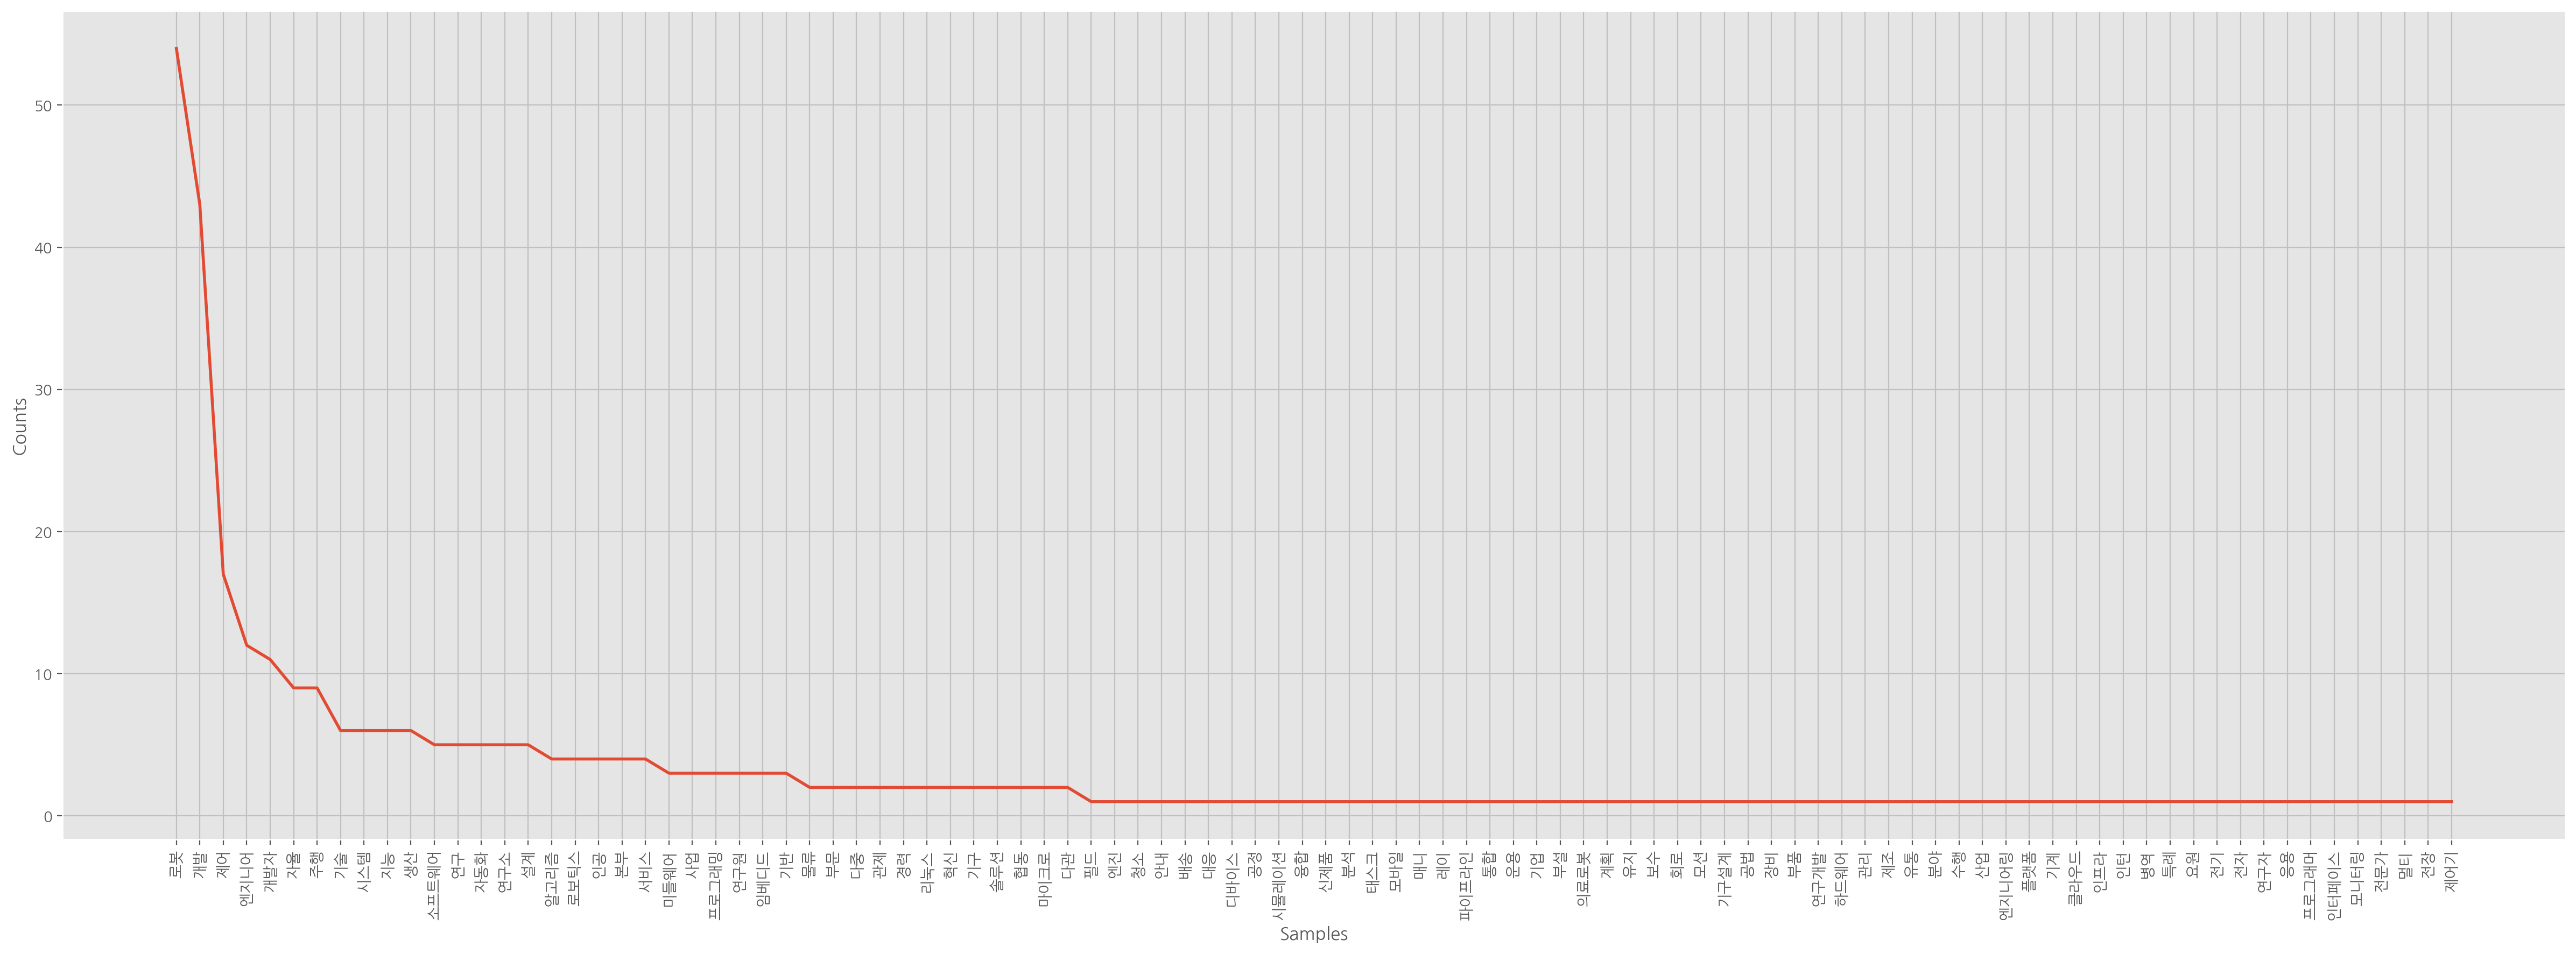

In [37]:
# 채용 포지션 전체 키워드 빈도수 그래프로 추이 살펴보기
plt.style.use('ggplot')
plt.figure(figsize=(30, 10))

ko_po = nltk.Text(po_word, name='ko_po')
ko_po.plot();

In [38]:
# 담당업무
# 키워드 빈도수 파악, 상위 20개
dam_word_count = Counter(dam_word)
dam_word_count_common20 = dam_word_count.most_common(20)
print(dam_word_count_common20)

df_dam_word_count_common20 = pd.DataFrame(dam_word_count_common20, columns=['담당업무_words', 'count'])
df_dam_word_count_common20

[('로봇', 164), ('개발', 150), ('제어', 52), ('설계', 51), ('기술', 42), ('기반', 41), ('시스템', 38), ('하다', 31), ('자동화', 27), ('알고리즘', 24), ('주행', 23), ('자율', 21), ('활용', 18), ('인식', 15), ('소프트웨어', 15), ('관리', 14), ('데이터', 14), ('플랫폼', 12), ('비다', 11), ('물류', 11)]


,담당업무_words,count
0,로봇,164
1,개발,150
2,제어,52
3,설계,51
4,기술,42
5,기반,41
6,시스템,38
7,하다,31
8,자동화,27
9,알고리즘,24


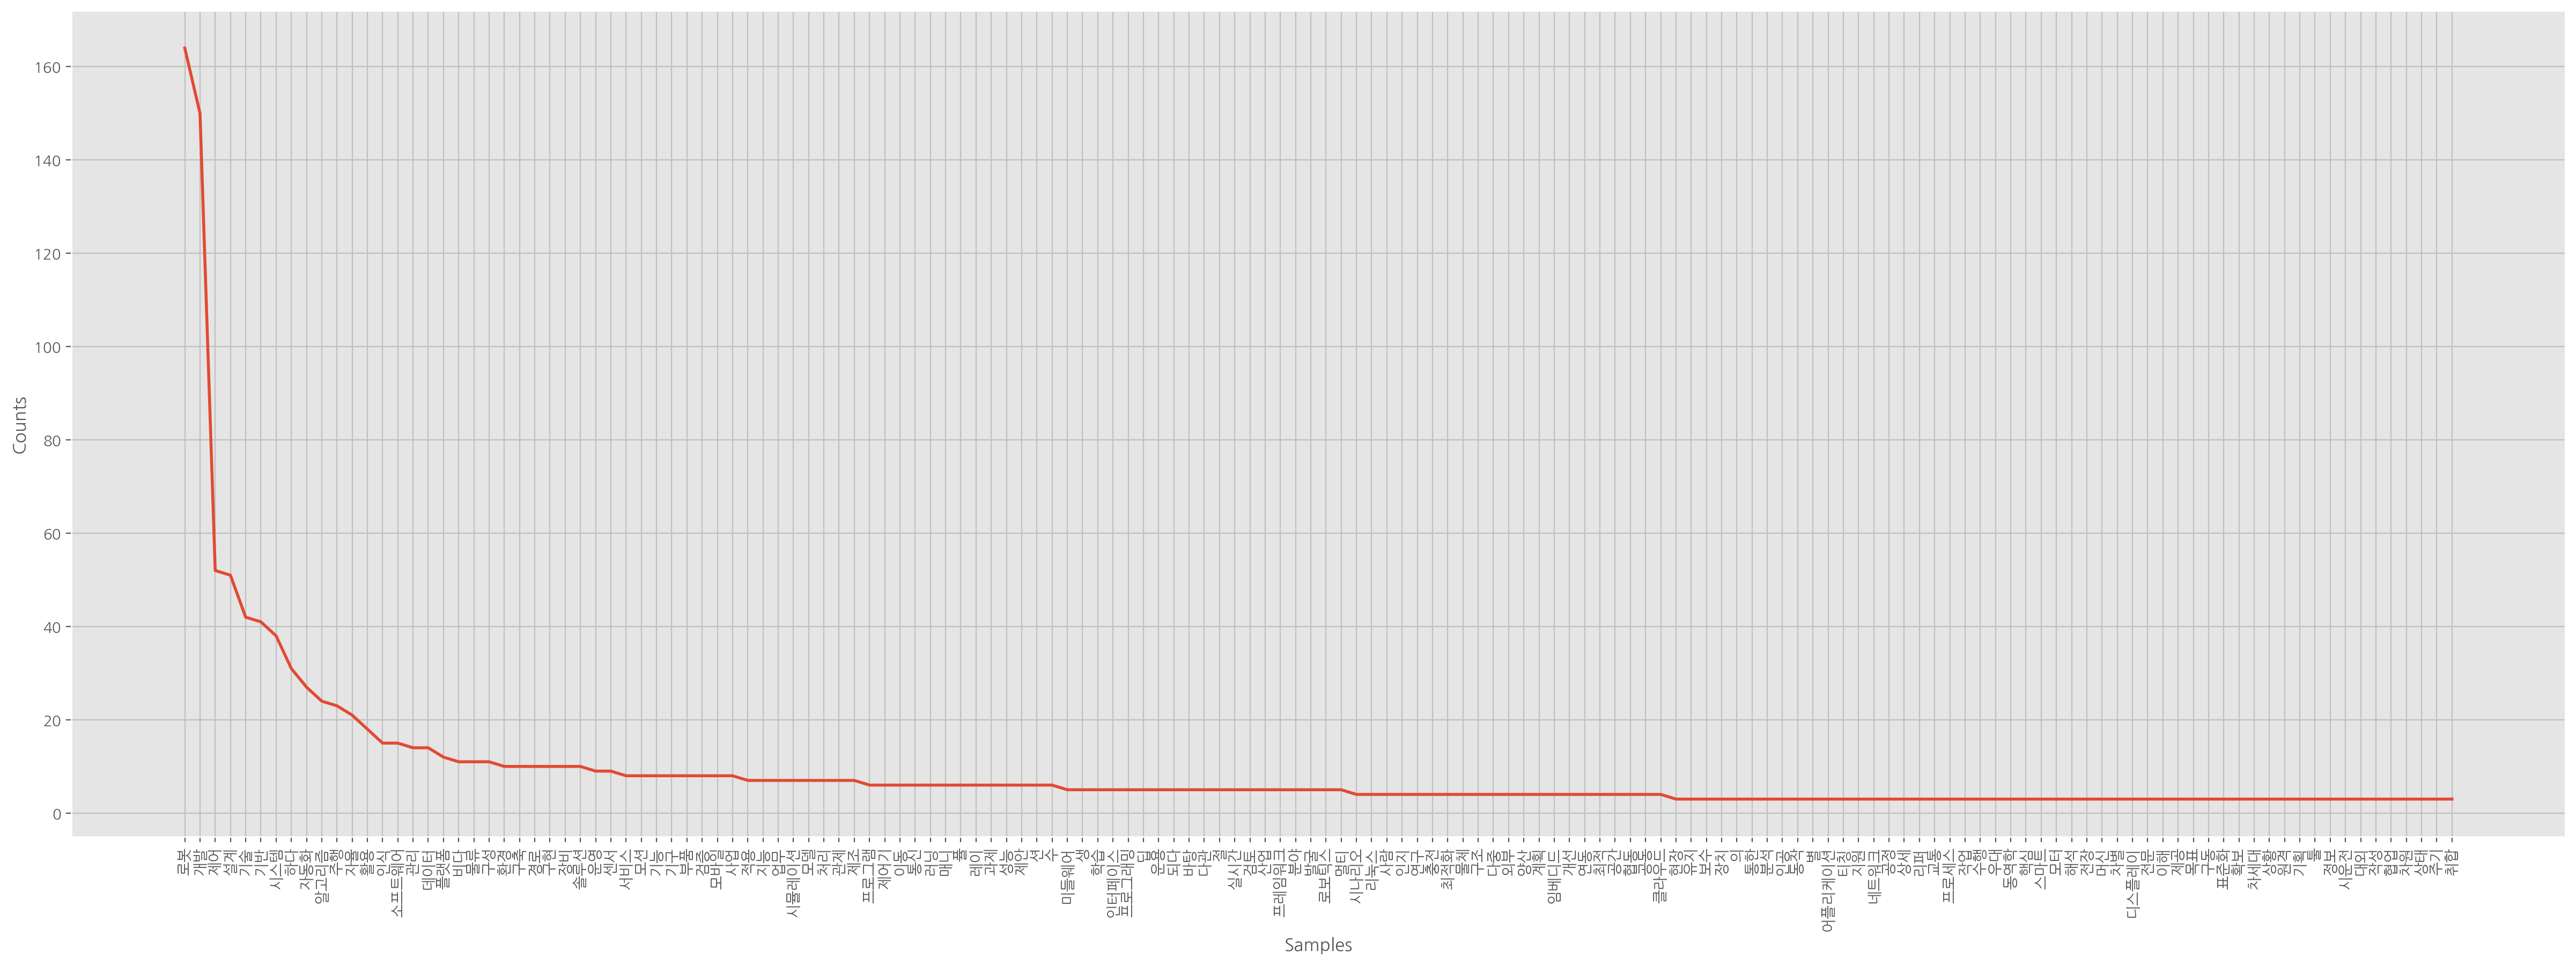

In [39]:
# 담당업무 전체 중 150개 키워드 빈도수 그래프로 추이 살펴보기
# expand image하여서 확대해서 살펴봐야 함
plt.figure(figsize=(30, 10))

ko_dam = nltk.Text(dam_word, name='ko_dam')
ko_dam.plot(150);

In [40]:
# 우대사항
# 키워드 빈도수 파악, 상위 20개
wo_word_count = Counter(wo_word)
wo_word_count_common20 = wo_word_count.most_common(20)
print(wo_word_count_common20)

df_wo_word_count_common20 = pd.DataFrame(wo_word_count_common20, columns=['우대사항_words', 'count'])
df_wo_word_count_common20

[('경험', 187), ('개발', 104), ('로봇', 65), ('가능', 26), ('설계', 24), ('보유', 23), ('기반', 23), ('제어', 22), ('시스템', 21), ('이상', 19), ('활용', 19), ('경력', 17), ('공학', 14), ('자동화', 13), ('사용', 13), ('분야', 12), ('대한', 12), ('석사', 12), ('전공', 12), ('통신', 11)]


,우대사항_words,count
0,경험,187
1,개발,104
2,로봇,65
3,가능,26
4,설계,24
5,보유,23
6,기반,23
7,제어,22
8,시스템,21
9,이상,19


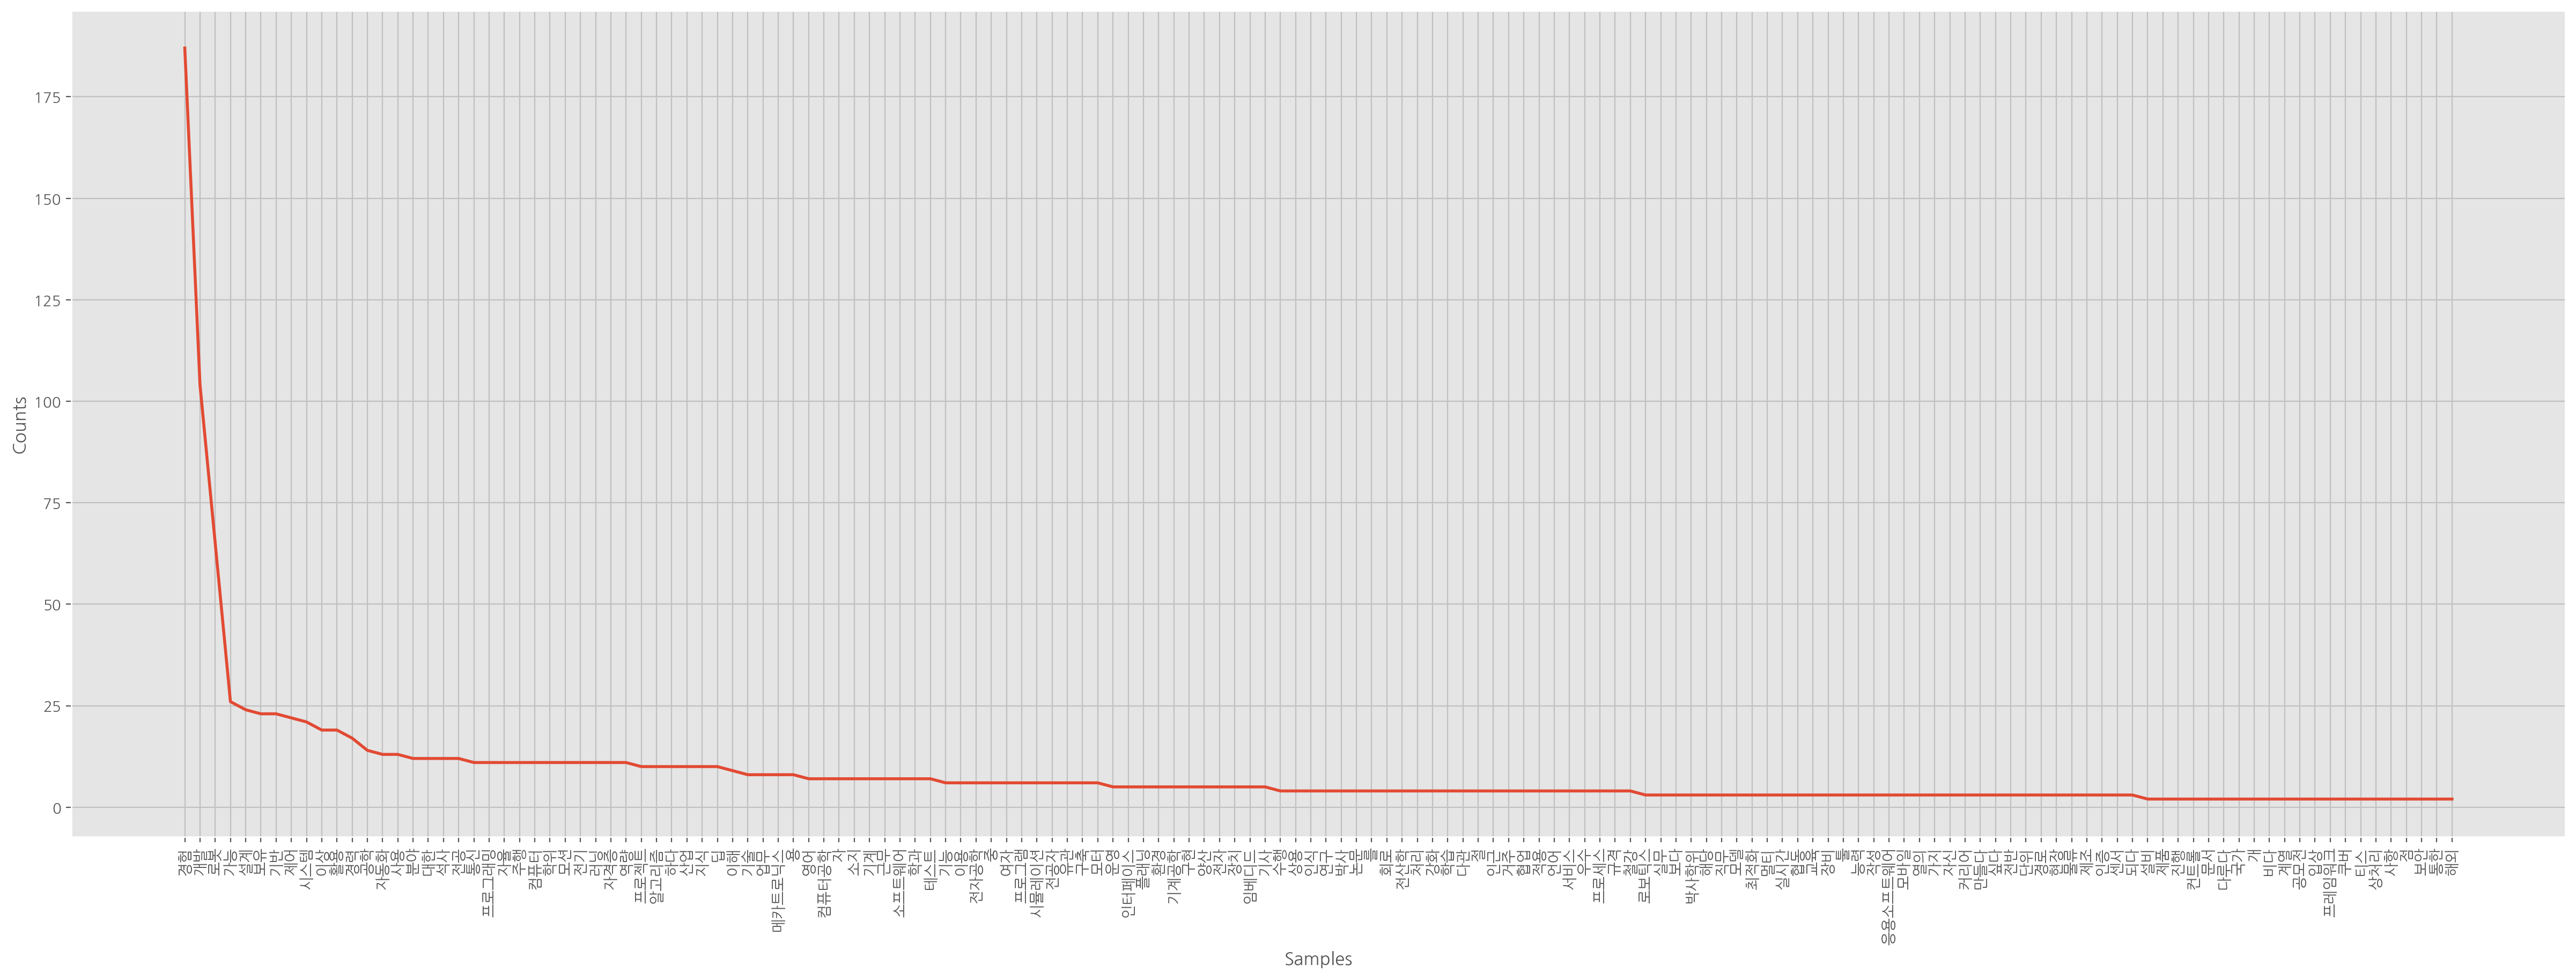

In [41]:
# 우대사항 전체 중 150개 키워드 빈도수 그래프 시각화
# expand image하여서 확대해서 살펴봐야 함
plt.figure(figsize=(30, 10))

ko_wo = nltk.Text(wo_word, name='ko_wo')
ko_wo.plot(150);

In [42]:
# 스킬
# 키워드 빈도수 파악
# 'C', '++' 합치기 등 해야 함
sk_word_count = Counter(sk_word)
sk_word_count_common20 = sk_word_count.most_common(20)
print(sk_word_count_common20)

df_sk_word_count_common20 = pd.DataFrame(sk_word_count_common20, columns=['스킬_words', 'count'])
df_sk_word_count_common20

[(',', 126), ('C', 77), ('N', 46), ('++,', 36), ('\n', 32), ('Python', 24), ('ROS', 22), ('Linux', 20), ('/', 19), ('#,', 8), ('2', 7), ('API', 6), ('Tensorflow', 4), ('Reactjs', 4), ('JAVA', 4), ('로봇', 3), ('OpenCV', 3), ('Visual', 3), ('Studio', 3), ('Javascript', 3)]


,스킬_words,count
0,",",126
1,C,77
2,N,46
3,"++,",36
4,\n,32
5,Python,24
6,ROS,22
7,Linux,20
8,/,19
9,"#,",8


In [43]:
len(sk_word_count)

87

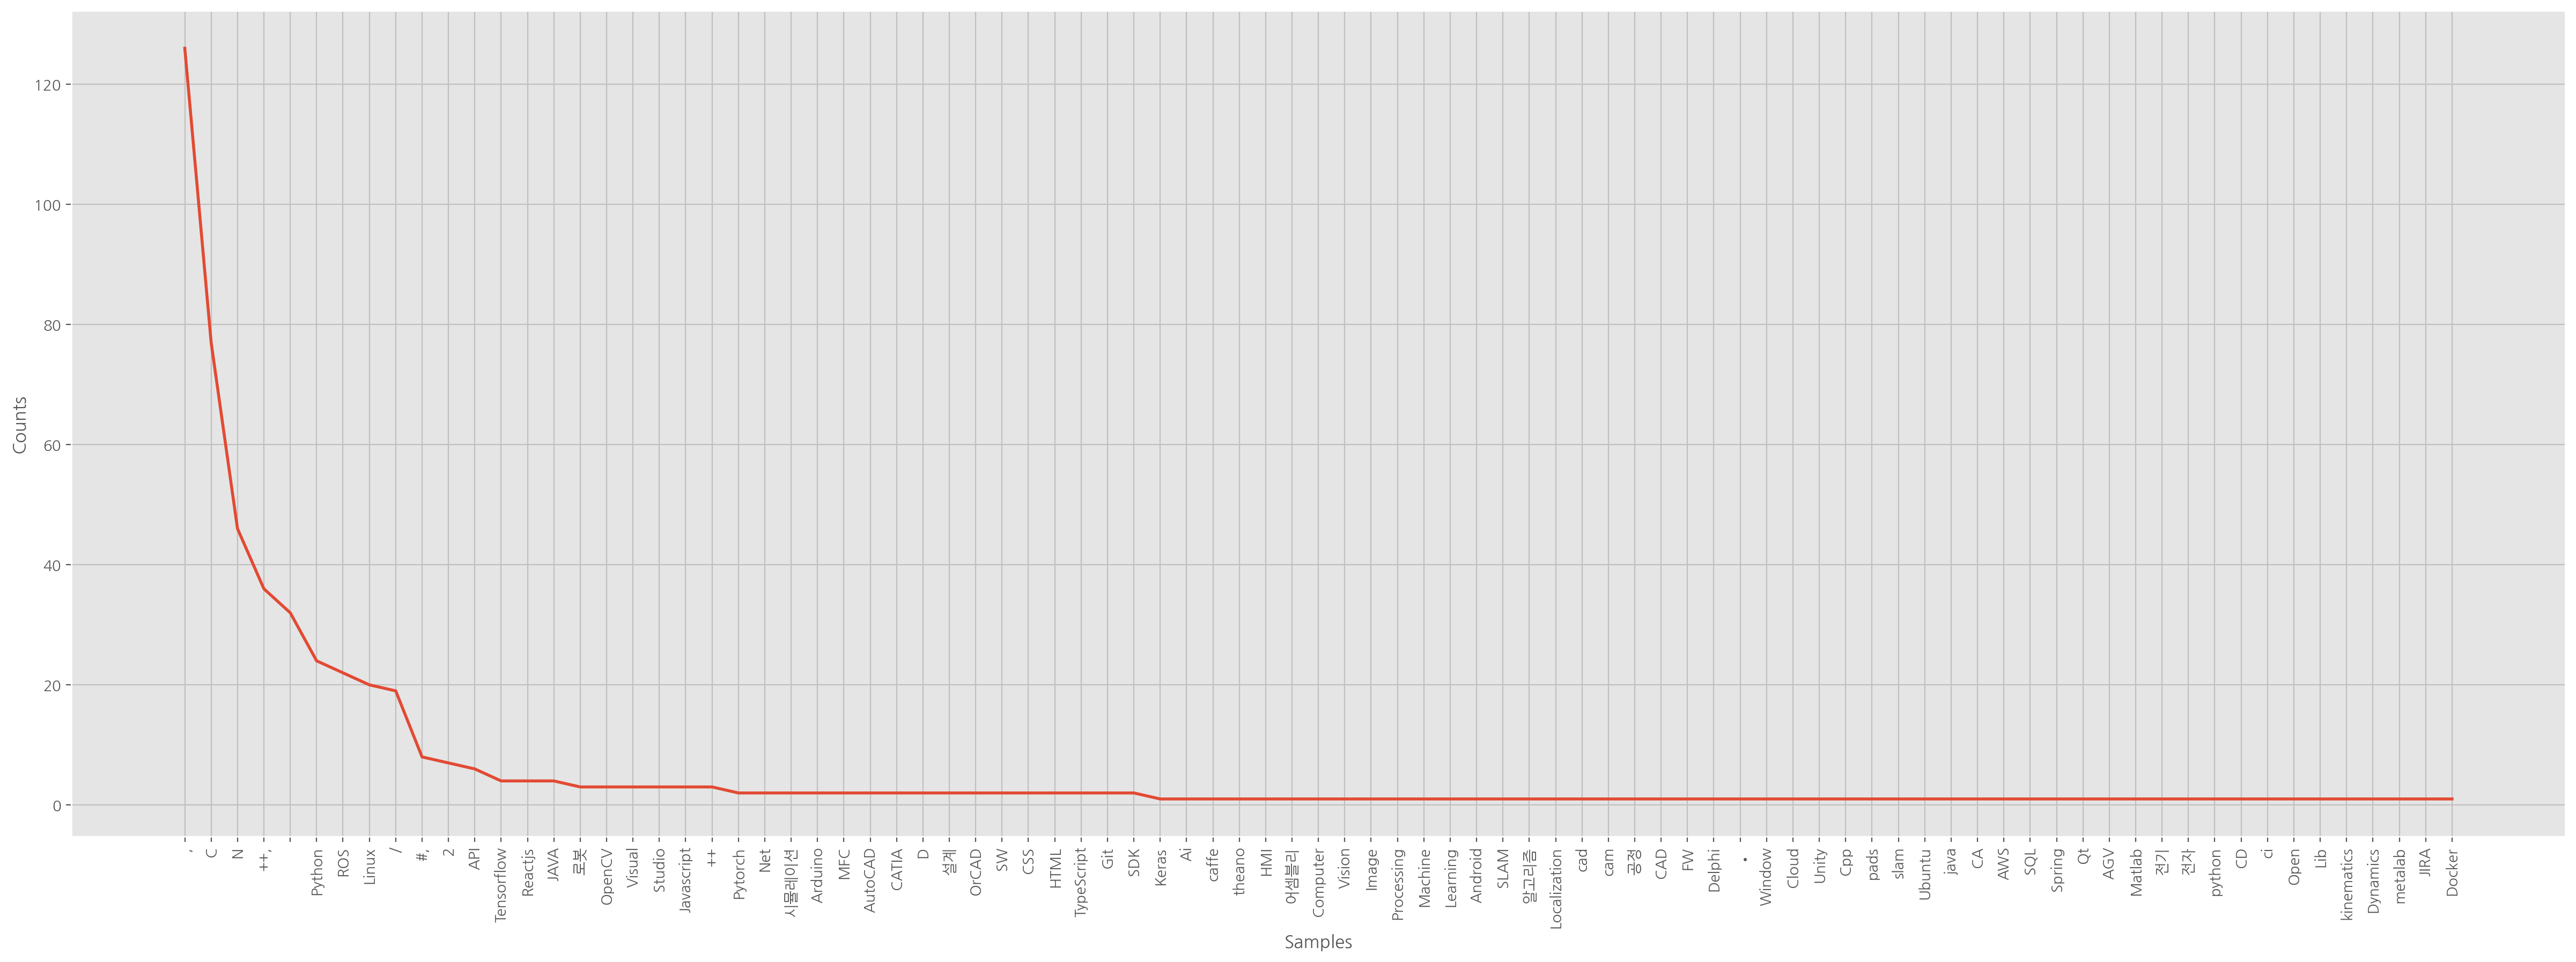

In [44]:
# 스킬 전체 중 150개 키워드 빈도수 그래프 시각화
# expand image하여서 확대해서 살펴봐야 함
plt.figure(figsize=(30, 10))

ko_sk = nltk.Text(sk_word, name='ko_sk')
ko_sk.plot();

#### 데이터 분포 - 그래프 시각화(채용포지션, 담당업무, 우대사항)

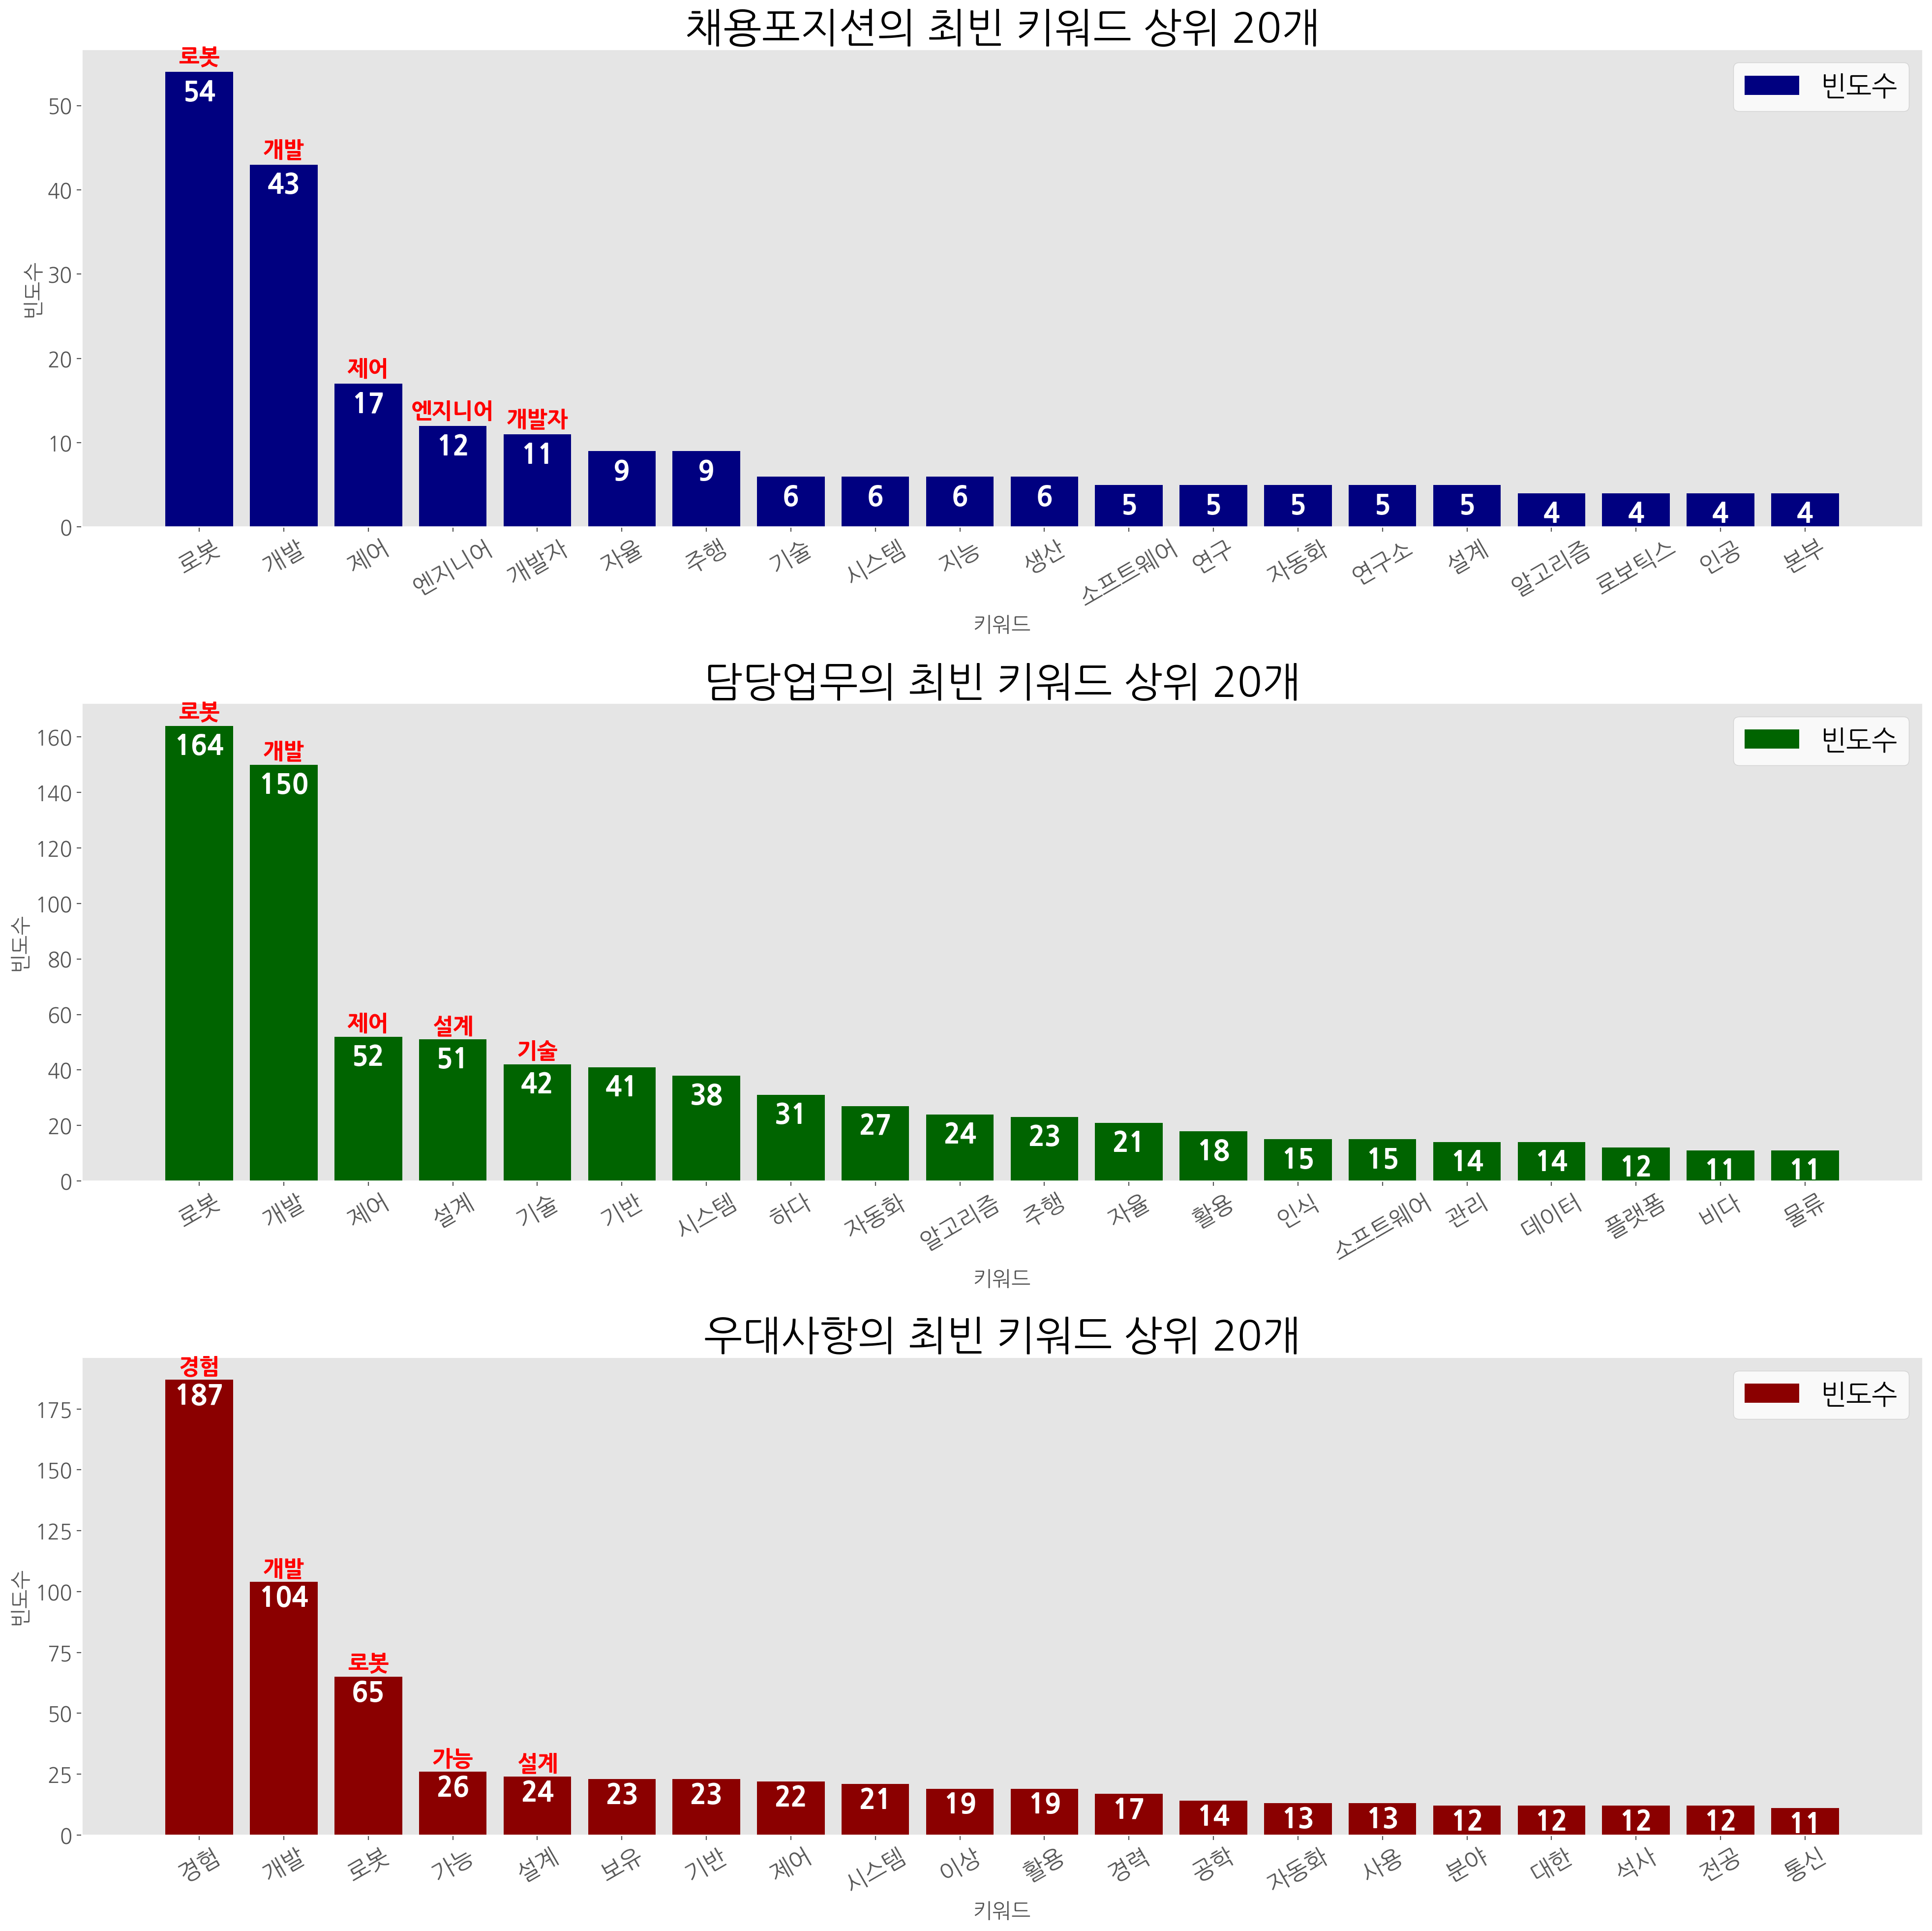

In [45]:
# 최빈 키워드 상위 20개 빈도수 그래프 시각화
plt.style.use('ggplot')
plt.figure(figsize=(20, 20))

#######################################
# 채용 포지션
plt.subplot(311)

bar1 = plt.bar(df_po_word_count_common20['채용포지션_명사'], df_po_word_count_common20["count"], color='navy')

for i in range(len(df_po_word_count_common20['채용포지션_명사'])):
    plt.text(df_po_word_count_common20['채용포지션_명사'][i], df_po_word_count_common20["count"][i]-4, df_po_word_count_common20["count"][i],
             fontsize = 20, 
             color='white',
             fontweight='bold',
             horizontalalignment='center',
             verticalalignment='bottom')
    
label_noun = ['로봇', '개발', '제어', '엔지니어', '개발자']

for i in range(5):
    plt.text(df_po_word_count_common20['채용포지션_명사'][i], df_po_word_count_common20["count"][i]+0.5, label_noun[i],
            fontsize = 16, 
            color='red',
            fontweight='bold',
            horizontalalignment='center',
            verticalalignment='bottom')

plt.legend([bar1], ['빈도수'], fontsize=20, facecolor='white')
plt.grid()
plt.xticks(fontsize=17, rotation = 30)
plt.yticks(fontsize=15)
plt.xlabel("키워드", fontsize=15)
plt.ylabel("빈도수", fontsize=15)
plt.title('채용포지션의 최빈 키워드 상위 20개', fontsize=30)
#######################################
# 담당업무
plt.subplot(312)

bar2 = plt.bar(df_dam_word_count_common20['담당업무_words'], df_dam_word_count_common20["count"], color='darkgreen')

for i in range(len(df_dam_word_count_common20['담당업무_words'])):
    plt.text(df_dam_word_count_common20['담당업무_words'][i], df_dam_word_count_common20["count"][i]-12, df_dam_word_count_common20["count"][i],
             fontsize = 20, 
             color='white',
             fontweight='bold',
             horizontalalignment='center',
             verticalalignment='bottom')
    
label_noun = ['로봇', '개발', '제어', '설계', '기술']

for i in range(5):
    plt.text(df_dam_word_count_common20['담당업무_words'][i], df_dam_word_count_common20["count"][i]+1, label_noun[i],
            fontsize = 16, 
            color='red',
            fontweight='bold',
            horizontalalignment='center',
            verticalalignment='bottom')

plt.legend([bar2], ['빈도수'], fontsize=20, facecolor='white')
plt.grid()
plt.xticks(fontsize=17, rotation = 30)
plt.yticks(fontsize=15)
plt.xlabel("키워드", fontsize=15)
plt.ylabel("빈도수", fontsize=15)
plt.title('담당업무의 최빈 키워드 상위 20개', fontsize=30)
#######################################
# 우대사항
plt.subplot(313)

bar3 = plt.bar(df_wo_word_count_common20['우대사항_words'], df_wo_word_count_common20["count"], color='darkred')

for i in range(len(df_wo_word_count_common20['우대사항_words'])):
    plt.text(df_wo_word_count_common20['우대사항_words'][i], df_wo_word_count_common20["count"][i]-12, df_wo_word_count_common20["count"][i],
             fontsize = 20, 
             color='white',
             fontweight='bold',
             horizontalalignment='center',
             verticalalignment='bottom')
    
label_noun = ['경험', '개발', '로봇', '가능', '설계']

for i in range(5):
    plt.text(df_wo_word_count_common20['우대사항_words'][i], df_wo_word_count_common20["count"][i]+1, label_noun[i],
            fontsize = 16, 
            color='red',
            fontweight='bold',
            horizontalalignment='center',
            verticalalignment='bottom')

plt.legend([bar3], ['빈도수'], fontsize=20, facecolor='white')
plt.grid()
plt.xticks(fontsize=17, rotation = 30)
plt.yticks(fontsize=15)
plt.xlabel("키워드", fontsize=15)
plt.ylabel("빈도수", fontsize=15)
plt.title('우대사항의 최빈 키워드 상위 20개', fontsize=30)

plt.tight_layout(pad=2)
plt.show();

#### 워드 클라우드

In [46]:
# 워드 클라우드는 리스트 형태가 아니라 띄어쓰기를 기준으로 단어들이 구분되는 문자열을 인식
po_words_data = ' '.join(po_word)
dam_words_data = ' '.join(dam_word)
wo_words_data = ' '.join(wo_word)
print(po_words_data)
# print(dam_words_data)
# print(wo_words_data)

로봇 필드 엔지니어 로봇 미들웨어 개발 자율 주행 엔진 개발 청소 로봇 개발 사업 엔지니어 자율 주행 로봇 개발자 로봇 개발자 로봇 안내 배송 물류 로봇 소프트웨어 개발 로봇 사업 부문 개발 로봇 제어 기술 대응 로봇 디바이스 제어 프로그래밍 로봇 공정 시뮬레이션 소프트웨어 개발자 로봇 알고리즘 개발 로봇 시스템 개발 융합 신제품 개발 분석 시스템 개발 엔지니어 로봇 미들웨어 개발자 로보틱스 소프트웨어 시스템 태스크 제어 로보틱스 소프트웨어 모바일 매니 레이 제어 파이프라인 개발 로봇 다중 로봇 통합 운용 제어 로봇 관제 시스템 로봇 인공 지능 연구 개발 자동화 엔지니어 기업 부설 연구소 로봇 개발 연구원 로봇 제어 자율 주행 개발자 의료로봇 계획 개발 유지 보수 지능 로봇 개발 경력 임베디드 리눅스 경력 개발자 로봇 개발 미들웨어 회로 설계 자율 주행 자율 주행 로봇 모션 제어 개발자 로봇 인공 지능 개발자 로봇 관제 개발 자율 주행 로봇 개발자 자동화 연구 생산 혁신 연구 로봇 연구 생산 혁신 연구 기구설계 생산 기술 본부 본부 본부 제어 생산 기술 로봇 부문 기술 개발 로봇 공법 장비 생산 기술 본부 생산 기술 제어 지능 로보틱스 개발 부품 개발 연구개발 로보틱스 개발 임베디드 개발자 기구 개발 엔지니어 하드웨어 개발 관리 로봇 자동화 설계 프로그래밍 제조 유통 물류 분야 로봇 자동화 설계 수행 산업 로봇 엔지니어링 프로그래밍 로봇 자동화 플랫폼 개발 소프트웨어 개발 연구원 기반 제어 개발 기계 로봇 제어 클라우드 인프라 시스템 개발 자율 주행 솔루션 개발 인공 지능 자율 주행 로봇 인턴 엔지니어 병역 특례 요원 로봇 전기 전자 연구자 개발자 연구원 개발 자율 주행 솔루션 사업 엔지니어 개발 임베디드 리눅스 응용 프로그래머 개발 개발 기반 협동 로봇 개발 로봇 시스템 개발 서비스 로봇 개발 로봇 인터페이스 마이크로 서비스 개발 로봇 인공 지능 서비스 알고리즘 개발 로봇 제어 모니터링 마이크로 서비스 개발 다관 로봇 제어 개발 다관 로봇 제어 알고리즘 개발

In [47]:
# 워드 클라우드 마스크 지정
cloud_po = np.array(Image.open('images/brain.png'))
cloud_dam = np.array(Image.open('images/brain.png'))
cloud_wo = np.array(Image.open('images/brain.png'))

In [48]:
# 한글 사용을 위해 가상환경에 한글 폰트 설치 후
# 경로 확인을 위해 font_list 확인
font_list = fm.findSystemFonts(fontpaths=None, fontext='ttf')
font_list

['/usr/share/fonts/opentype/urw-base35/NimbusSans-BoldItalic.otf',
 '/usr/share/fonts/opentype/urw-base35/C059-BdIta.otf',
 '/usr/share/fonts/truetype/tlwg/TlwgTypo-BoldOblique.ttf',
 '/usr/share/fonts/truetype/lohit-telugu/Lohit-Telugu.ttf',
 '/usr/share/fonts/opentype/noto/NotoSerifCJK-SemiBold.ttc',
 '/usr/share/fonts/truetype/tlwg/TlwgTypo-Oblique.ttf',
 '/usr/share/fonts/truetype/fonts-gujr-extra/Rekha.ttf',
 '/usr/share/fonts/truetype/teluguvijayam/TimmanaRegular.ttf',
 '/usr/share/fonts/truetype/freefont/FreeSansBold.ttf',
 '/usr/share/fonts/opentype/mathjax/MathJax_Size2-Regular.otf',
 '/usr/share/fonts/truetype/dejavu/DejaVuSansMono-BoldOblique.ttf',
 '/usr/share/fonts/truetype/teluguvijayam/Suravaram.ttf',
 '/usr/share/fonts/truetype/ubuntu/Ubuntu-LI.ttf',
 '/usr/share/fonts/truetype/nanum/NanumSquare_acEB.ttf',
 '/usr/share/fonts/truetype/lyx/esint10.ttf',
 '/usr/share/fonts/truetype/tlwg/TlwgMono-BoldOblique.ttf',
 '/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf',
 '/u

(-0.5, 399.5, 199.5, -0.5)

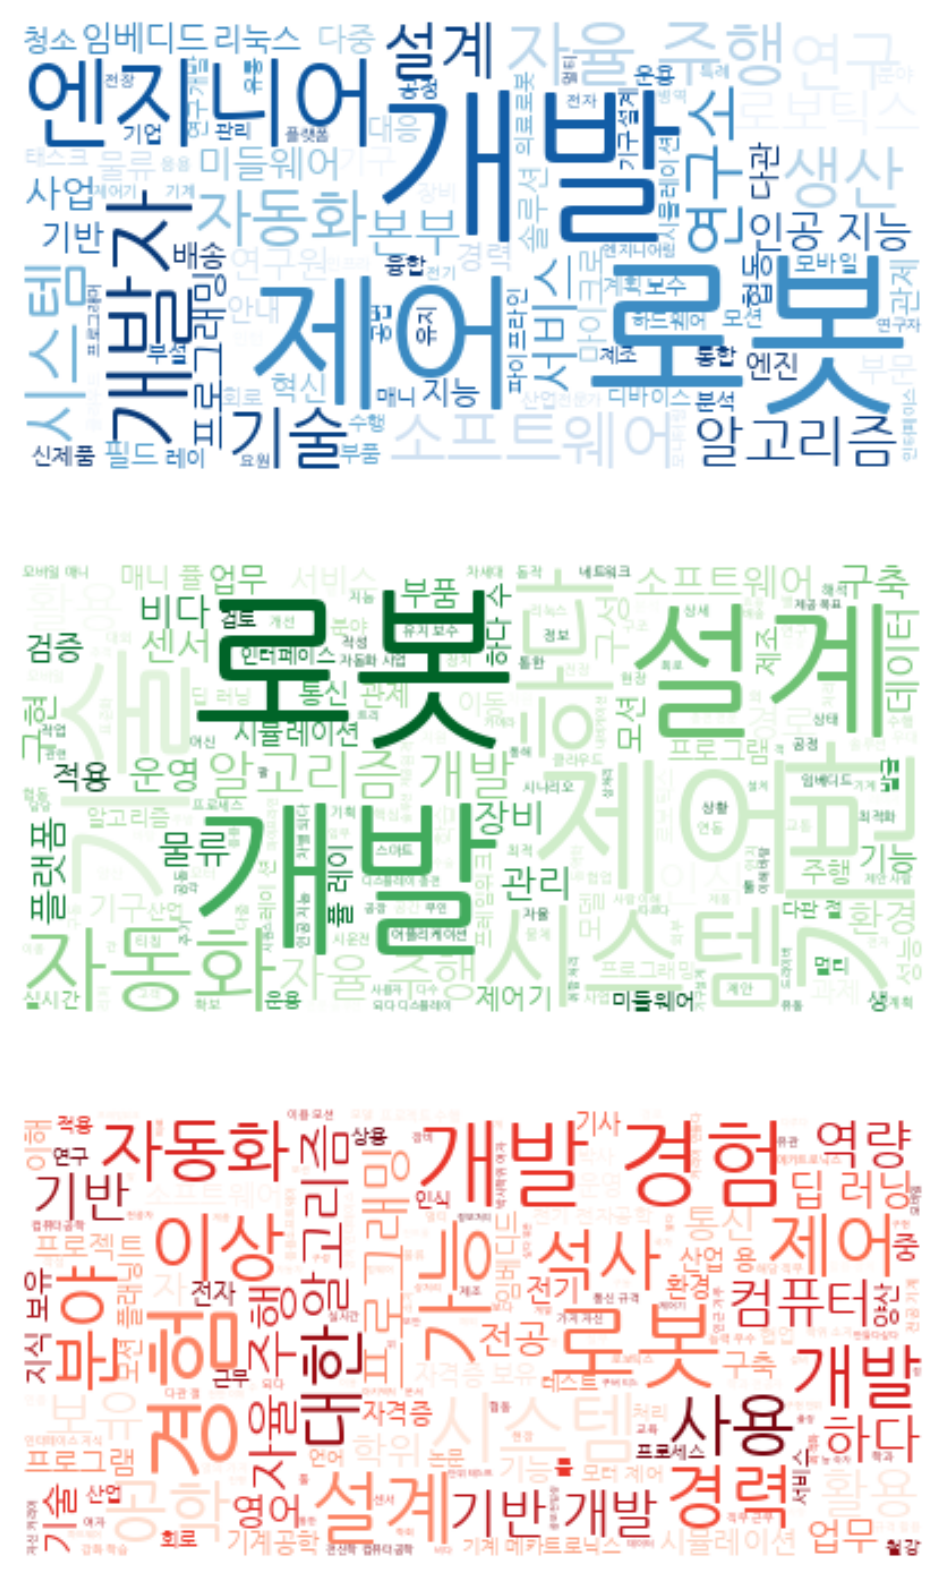

In [49]:
# 워드 클라우드
plt.figure(figsize=(10,10))

# 채용공고
plt.subplot(311)

wc = wordcloud = WordCloud(
    max_words = 2000,
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    background_color='white',
    colormap='Blues',
    relative_scaling=0.2,
    # mask=cloud_po
).generate(po_words_data)

plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
#######################################
# 담당업무
plt.subplot(312)

wc2 = wordcloud = WordCloud(
    max_words = 2000,
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    background_color='white',
    colormap='Greens',
    relative_scaling=0.2,
    # mask=cloud_dam
).generate(dam_words_data)

plt.imshow(wc2,interpolation='bilinear')
plt.axis('off')
#######################################
# 우대사항
plt.subplot(313)

wc = wordcloud = WordCloud(
    max_words = 2000,
    font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    background_color='white',
    colormap='Reds',
    relative_scaling=0.2,
    # mask=cloud_wo
).generate(wo_words_data)

plt.imshow(wc,interpolation='bilinear')
plt.axis('off')